# Predicting YouTube Virality from Video Metadata

## Setup

In [1]:
# Imports
import os
import pandas as pd
import requests
import time
from tqdm import tqdm
from googleapiclient.discovery import build
from google.colab import userdata

### Obtaining Data

In [13]:
# Config
API_KEY = userdata.get('YOUTUBE_API_KEY') # Get API key from Colab Secrets
INPUT_CSV = "USvideos.csv"  # Input data (must contain video ids)
OUTPUT_DIR = "yt_data" # Output directory
THUMBNAIL_DIR = os.path.join(OUTPUT_DIR, "thumbnails") # Specify output subdirectory for thumbnails
os.makedirs(THUMBNAIL_DIR, exist_ok=True) # Make directory if it doesn't exist

# Load video ids
df_ids = pd.read_csv(INPUT_CSV) # Load input data
df_ids = df_ids.drop_duplicates(subset='video_id') # Remove entries with duplicate video id
video_ids = df_ids['video_id'].dropna().tolist() # Remove N/A entries

# Set up YT Data API
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_video_data(video_id_batch):
  """
  Fetch video metadata from YouTube Video API route

  Args:
    video_id_batch: Batch of video ids

  Returns:
    List of video metadata
  """

  # Initialize query
  request = youtube.videos().list(
    part='snippet,statistics,contentDetails,status',
    id=','.join(video_id_batch)
  )

  # Get output from query
  response = request.execute()

  # Initialize list of result data
  data = []

  # Parse query output for desired fields
  for item in response.get('items', []):
    data.append({
      'video_id': item['id'],
      'channelId': item['snippet']['channelId'],
      'title': item['snippet']['title'],
      'description': item['snippet'].get('description', ''),
      'publishedAt': item['snippet']['publishedAt'],
      'tags_count': len(item['snippet'].get('tags', [])),
      'categoryId': item['snippet'].get('categoryId'),
      'duration': item['contentDetails']['duration'],
      'definition': item['contentDetails']['definition'],
      'caption': item['contentDetails']['caption'],
      'privacyStatus': item['status']['privacyStatus'],
      'embeddable': item['status'].get('embeddable', False),
      'viewCount': item['statistics'].get('viewCount'),
      'likeCount': item['statistics'].get('likeCount'),
      'commentCount': item['statistics'].get('commentCount'),
    })

  return data # Return data as list

# Initialize list of video metadata
all_metadata = []

# Parse list of video ids with batch size = 50
for i in tqdm(range(0, len(video_ids), 50)):
  batch = video_ids[i:i + 50] # Initialize new batch
  try:
    all_metadata.extend(get_video_data(batch)) # Append data for new batch
  except Exception as e:
    print(f"Error with batch {i}: {e}")
  time.sleep(1)

metadata_df = pd.DataFrame(all_metadata) # Create Pandas dataframe of metadata

def get_channel_stats(channel_ids):
  """
  Fetch channel metadata from YouTube Channel API route

  Args:
    channel_ids: Batch of channel ids

  Returns:
    List of channel metadata
  """

  # Initialize list of channel metadata
  stats = []

  # Parse list of channel ids with batch size = 50
  for i in tqdm(range(0, len(channel_ids), 50)):
    batch = channel_ids[i:i + 50] # Initialize new batch
    try:
      # Initialize query
      request = youtube.channels().list(
        part='statistics',
        id=','.join(batch)
      )
      # Get output from query
      response = request.execute()

      # Parse query output for desired fields
      for item in response['items']:
        stats.append({
          'channelId': item['id'],
          'subscriberCount': item['statistics'].get('subscriberCount')
        })
    except Exception as e:
      print(f"Error with channel batch {i}: {e}")
    time.sleep(1)
  return pd.DataFrame(stats) # Return data as dataframe

unique_channels = metadata_df['channelId'].dropna().unique() # Filter unique channels
channel_stats_df = get_channel_stats(unique_channels) # Get subscriber count for unique channels

# Merge metadata with retrieved subscriber counts
metadata_df = metadata_df.merge(channel_stats_df, on='channelId', how='left')
metadata_df['subscriberCount'] = pd.to_numeric(metadata_df['subscriberCount'], errors='coerce')

def download_thumbnail(video_id):
  """
  Download high resolution thumbnail for video

  Args:
    video_id: Video id
  """

  # Set URL to access thumbnail image from
  url = f"https://img.youtube.com/vi/{video_id}/hqdefault.jpg"

  # Execute query
  try:
    r = requests.get(url) # Get image from URL

    # Check for successful status code
    if r.status_code == 200:
      # Open image as file
      with open(os.path.join(THUMBNAIL_DIR, f"{video_id}.jpg"), 'wb') as f:
        f.write(r.content) # Write file to thumbnail directory
  except Exception as e:
    print(f"Failed to download thumbnail for {video_id}: {e}")

# Download and save thumbnail for each video
for vid in tqdm(metadata_df['video_id']):
  download_thumbnail(vid)

100%|██████████| 5719/5719 [02:54<00:00, 32.74it/s]


### Saving Data

In [14]:
# Save final metadata in csv format
metadata_df.to_csv(os.path.join(OUTPUT_DIR, "metadata_raw.csv"), index=False)
print("All data saved to yt_data/metadata_raw.csv and thumbnails/")

All data saved to yt_data/metadata_raw.csv and thumbnails/


In [15]:
# Compress data folder
!zip -r youtube_metadata.zip yt_data/

Streaming output truncated to the last 5000 lines.
  adding: yt_data/thumbnails/zFuOksI6AVg.jpg (deflated 2%)
  adding: yt_data/thumbnails/34cHO5_LX9g.jpg (deflated 2%)
  adding: yt_data/thumbnails/v8VMdSQL50w.jpg (deflated 2%)
  adding: yt_data/thumbnails/XIxZLrruFpg.jpg (deflated 3%)
  adding: yt_data/thumbnails/Ff7wbSwTuEk.jpg (deflated 6%)
  adding: yt_data/thumbnails/jPkRGHivRD8.jpg (deflated 2%)
  adding: yt_data/thumbnails/7dNu1AorSYc.jpg (deflated 2%)
  adding: yt_data/thumbnails/sfxilYIycTc.jpg (deflated 2%)
  adding: yt_data/thumbnails/FHl0nIdbiLA.jpg (deflated 5%)
  adding: yt_data/thumbnails/8qW6fjiMhgo.jpg (deflated 2%)
  adding: yt_data/thumbnails/Fr0wEsISRUw.jpg (deflated 8%)
  adding: yt_data/thumbnails/IX3_Aqji4yE.jpg (deflated 2%)
  adding: yt_data/thumbnails/yirvgC-kMq0.jpg (deflated 3%)
  adding: yt_data/thumbnails/6SuMbFuKDf8.jpg (deflated 4%)
  adding: yt_data/thumbnails/-IqpbDJFbZA.jpg (deflated 2%)
  adding: yt_data/thumbnails/6Detw08jRhs.jpg (deflated 8%)
  add

## Data

In [1]:
!unzip youtube_metadata.zip # Unzip data file

Streaming output truncated to the last 5000 lines.
  inflating: yt_data/thumbnails/B5HORANmzHw.jpg  
  inflating: yt_data/thumbnails/zFuOksI6AVg.jpg  
  inflating: yt_data/thumbnails/34cHO5_LX9g.jpg  
  inflating: yt_data/thumbnails/v8VMdSQL50w.jpg  
  inflating: yt_data/thumbnails/XIxZLrruFpg.jpg  
  inflating: yt_data/thumbnails/Ff7wbSwTuEk.jpg  
  inflating: yt_data/thumbnails/jPkRGHivRD8.jpg  
  inflating: yt_data/thumbnails/7dNu1AorSYc.jpg  
  inflating: yt_data/thumbnails/sfxilYIycTc.jpg  
  inflating: yt_data/thumbnails/FHl0nIdbiLA.jpg  
  inflating: yt_data/thumbnails/8qW6fjiMhgo.jpg  
  inflating: yt_data/thumbnails/Fr0wEsISRUw.jpg  
  inflating: yt_data/thumbnails/IX3_Aqji4yE.jpg  
  inflating: yt_data/thumbnails/yirvgC-kMq0.jpg  
  inflating: yt_data/thumbnails/6SuMbFuKDf8.jpg  
  inflating: yt_data/thumbnails/-IqpbDJFbZA.jpg  
  inflating: yt_data/thumbnails/6Detw08jRhs.jpg  
  inflating: yt_data/thumbnails/EGV9Ms9EHcg.jpg  
  inflating: yt_data/thumbnails/2BIx2x-Q2fE.jpg  

In [2]:
!rm -rf youtube_metadata.zip # Remove zip file

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Debug Config
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Loading Data

In [4]:
# Load the metadata
df = pd.read_csv("yt_data/metadata_raw.csv")

### Cleaning Data

In [5]:
# Clean up or encode values
df['duration_seconds'] = pd.to_timedelta(df['duration']).dt.total_seconds()
df['description_length'] = df['description'].fillna('').apply(len)
df['title_length'] = df['title'].fillna('').apply(len)
df['caption'] = df['caption'].astype(int)
df['definition'] = df['definition'].map({'hd': 1, 'sd': 0})
df['embeddable'] = df['embeddable'].astype(int)

# Extract publishing date/time information
df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
df['publish_hour'] = df['publishedAt'].dt.hour
df['publish_dayofweek'] = df['publishedAt'].dt.dayofweek

# Retrieve category names
with open('US_category_id.json') as f:
  cat_data = json.load(f)

# Map category ids to category names
cat_map = {int(item['id']): item['snippet']['title'] for item in cat_data['items']}
df['category_name'] = df['categoryId'].map(cat_map)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['category_name', 'publish_hour', 'publish_dayofweek'], drop_first=True, dtype=int)

# Drop N/A values (due to private videos)
df = df.dropna(subset=['likeCount', 'commentCount', 'viewCount']).reset_index(drop=True)

# Delineate numeric columns
numeric_cols = ['tags_count', 'duration_seconds', 'likeCount', 'commentCount',
                'description_length', 'title_length', 'subscriberCount']

# Delineate binary columns
binary_cat_cols = ['caption', 'definition', 'embeddable']

# Delineate one-hot encoded columns
dummy_cols = [col for col in df.columns if col.startswith('category_name_') or col.startswith('publish_')]

# Store names of each feature/weight (for future reference)
feature_names = (['intercept'] +
                 numeric_cols +
                 binary_cat_cols +
                 dummy_cols)

# Scale numeric features
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(df[numeric_cols])

# Combined scaled numeric features with binary and one-hot encoded columns
X_other = df[binary_cat_cols + dummy_cols].values
X_combined = np.column_stack((np.ones(len(df)), X_numeric_scaled, X_other))

# Convert view count (target variable) to log-scale
y = np.log1p(df['viewCount'].values)

# Split data for 80-20 train-test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

## Bayesian Analysis

In [55]:
# Imports
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import pandas as pd

In [56]:
def multivariate_normal_rvs_manual(mean, cov, size=1):
  mean = np.asarray(mean)
  cov = np.asarray(cov)
  d = len(mean)
  # Cholesky decomposition of covariance matrix
  L = np.linalg.cholesky(cov)
  # Sample standard normal and transform
  Z = np.random.randn(size, d)
  samples = mean + Z @ L.T
  return samples if size > 1 else samples[0]

def invgamma_rvs_manual(a, scale=1.0, size=1):
  # Sample from a gamma distribution
  gamma_samples = np.random.gamma(shape=a, scale=1/scale, size=size)
  # Take the reciprocal to get inverse gamma samples
  return 1 / gamma_samples

def norm_rvs_manual(loc=0.0, scale=1.0, size=1):
  # Sample from standard normal and scale/shift
  standard_normal = np.random.randn(size)
  return loc + scale * standard_normal

### Priors

In [57]:
# Find length and number of features, respectively, of training set.
n, p = X_train.shape

# Prior for w
prior_w = np.zeros((p, 1)) # w^{(0)}
prior_Sigma = np.eye(p) * 100 # Σ_0

# Prior for sigma²
prior_alpha = 2 # α_0
prior_beta = 10 # β_0

### Gibbs Sampler

In [58]:
# Gibbs Sampling parameters

eta = 5000 # Number of iterations
gibbs_samples_w = np.zeros((eta, p)) # Store w samples
gibbs_samples_sigmay = np.zeros(eta) # Store sigma² samples

# Initial values
w_tilde_current = np.zeros((p, 1)) # Initial weight
sigma2_current = 1 # Initial sigma²

In [59]:
# Run the sampler
for i in range(eta):
  # Conditional posterior parameters for w
  V = np.linalg.inv((1/sigma2_current) * (X_train.T @ X_train) + np.linalg.inv(prior_Sigma))
  M = V @ ((1/sigma2_current) * (X_train.T @ y_train.reshape(-1,1)) + np.linalg.inv(prior_Sigma) @ prior_w)

  # Sample weights
  w_tilde_current = multivariate_normal_rvs_manual(mean=M.flatten(), cov=V).reshape(p, 1)

  # Conditional posterior parameters for sigma²
  residual = y_train.reshape(-1, 1) - X_train @ w_tilde_current
  A = (2 * prior_alpha + n) / 2
  B = (2 * prior_beta + (residual.T @ residual))[0, 0] / 2

  # Sample sigma²
  sigma2_current = invgamma_rvs_manual(a=A, scale=B)

  # Store samples
  gibbs_samples_w[i, :] = w_tilde_current.flatten()
  gibbs_samples_sigmay[i] = sigma2_current[0]

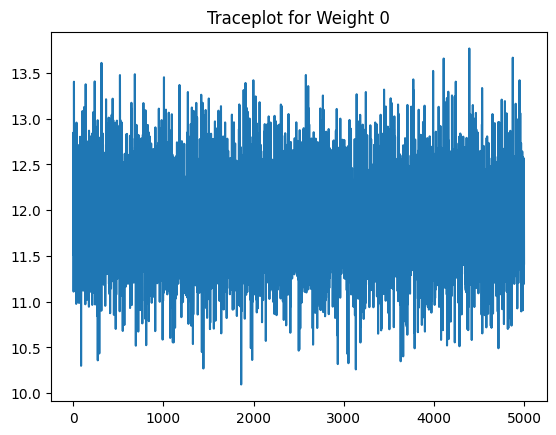

<Figure size 640x480 with 0 Axes>

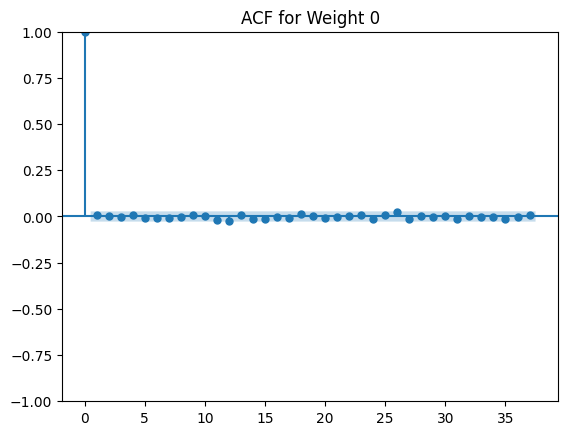

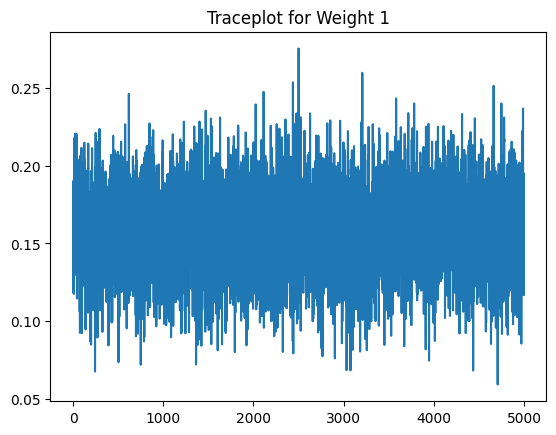

<Figure size 640x480 with 0 Axes>

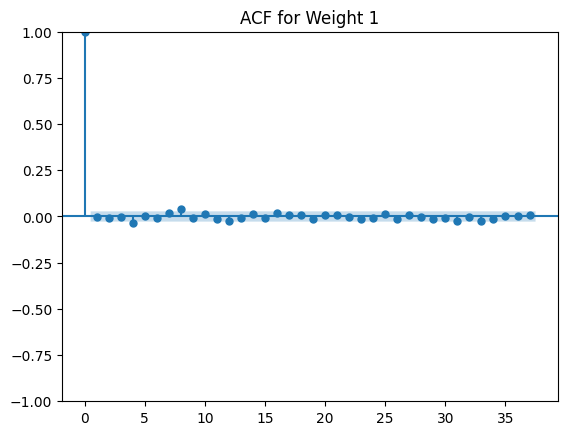

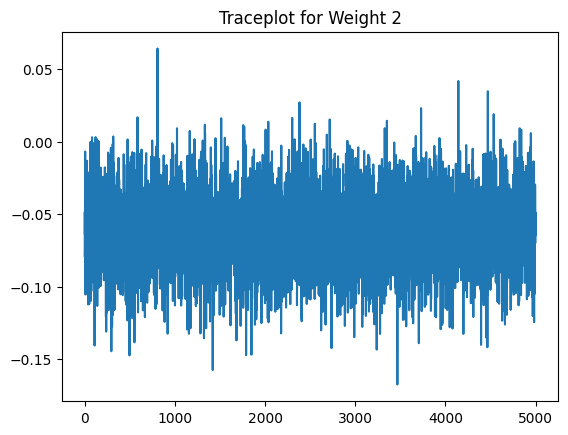

<Figure size 640x480 with 0 Axes>

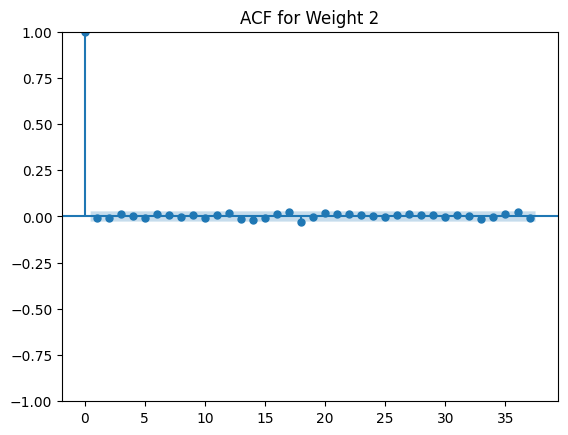

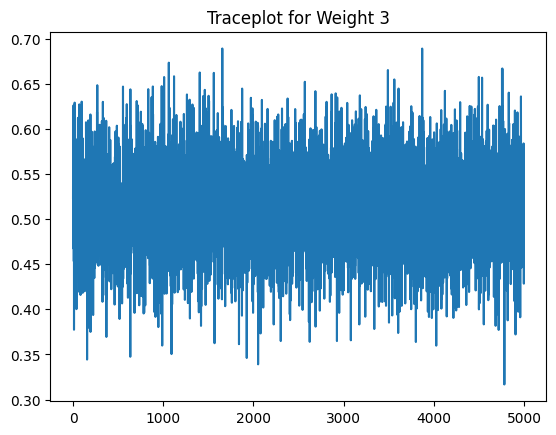

<Figure size 640x480 with 0 Axes>

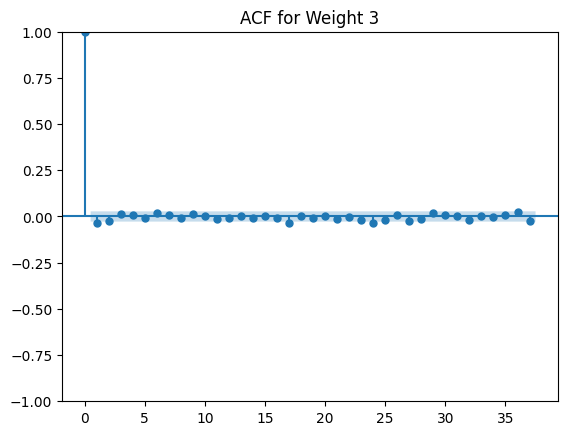

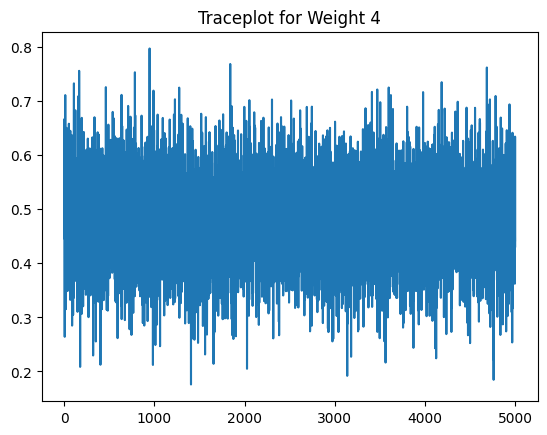

<Figure size 640x480 with 0 Axes>

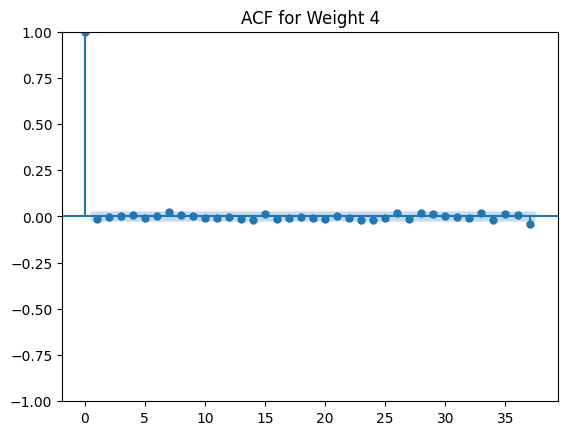

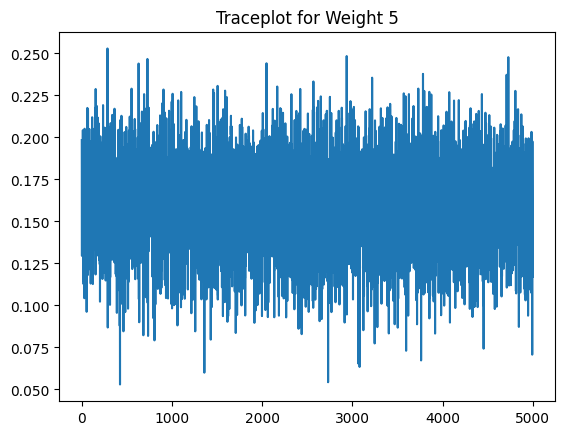

<Figure size 640x480 with 0 Axes>

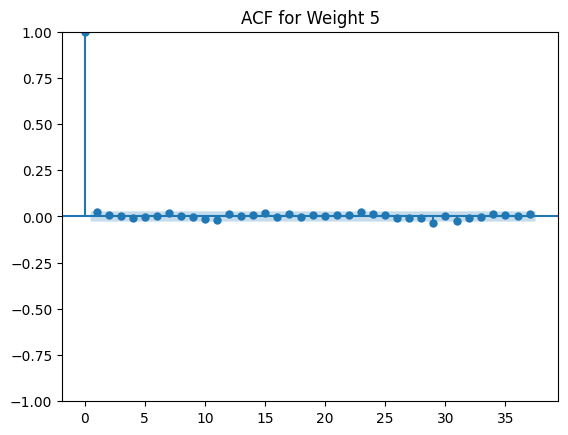

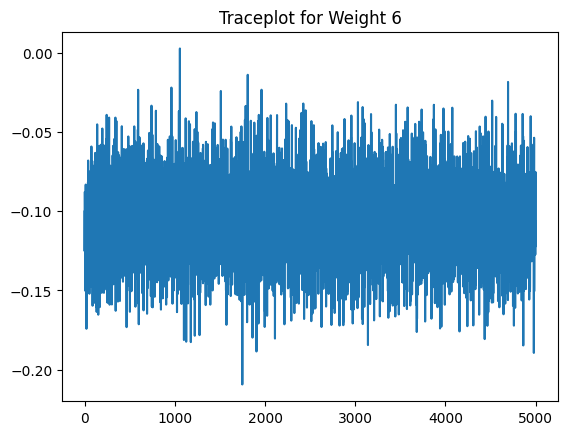

<Figure size 640x480 with 0 Axes>

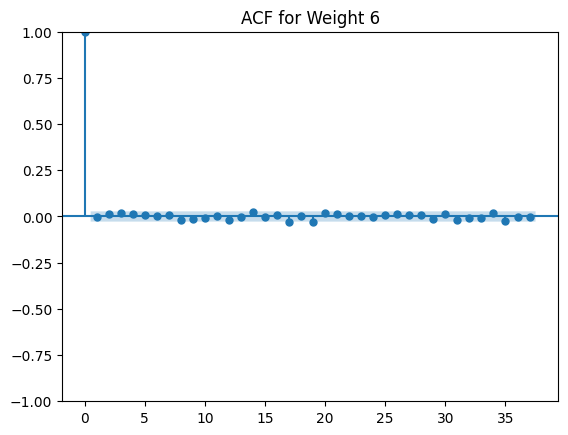

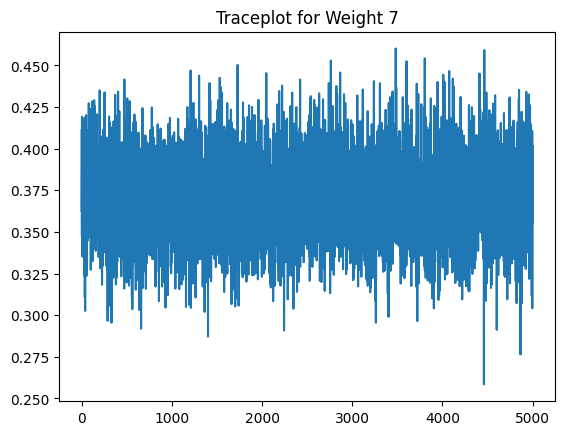

<Figure size 640x480 with 0 Axes>

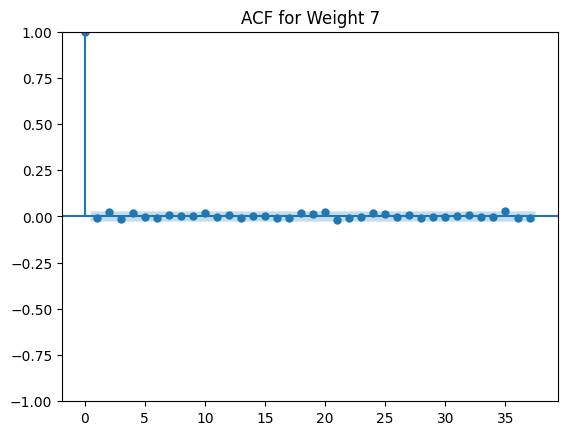

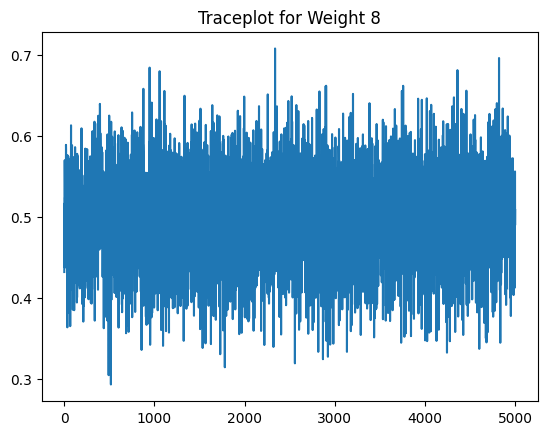

<Figure size 640x480 with 0 Axes>

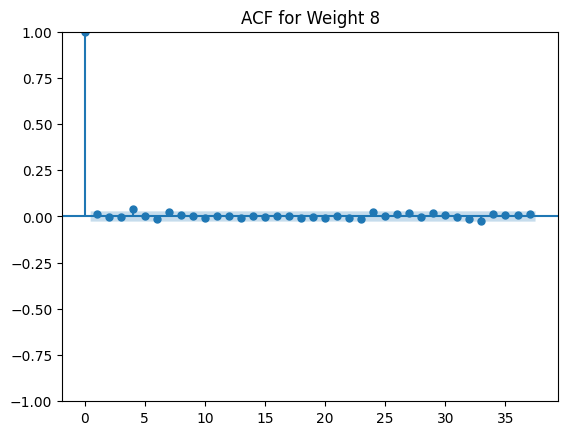

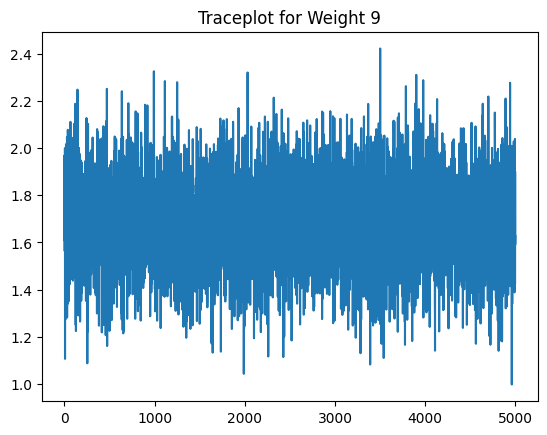

<Figure size 640x480 with 0 Axes>

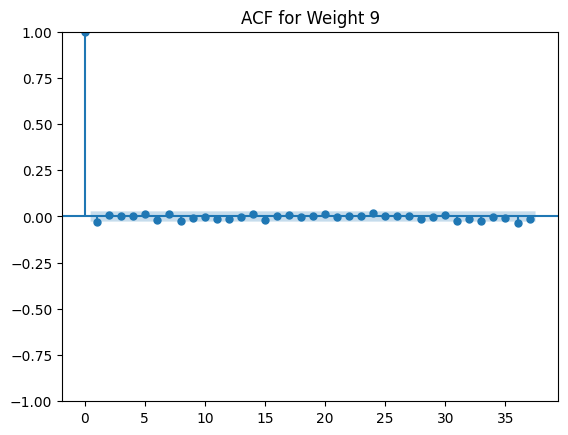

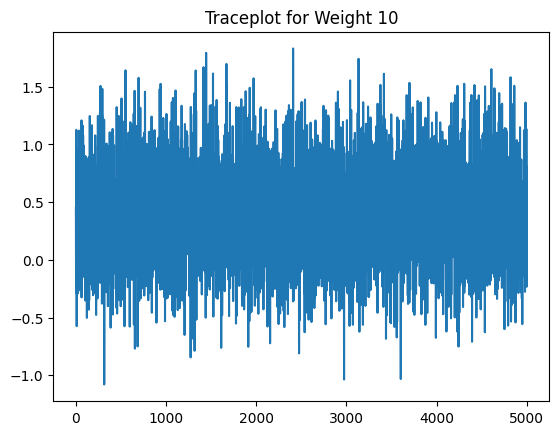

<Figure size 640x480 with 0 Axes>

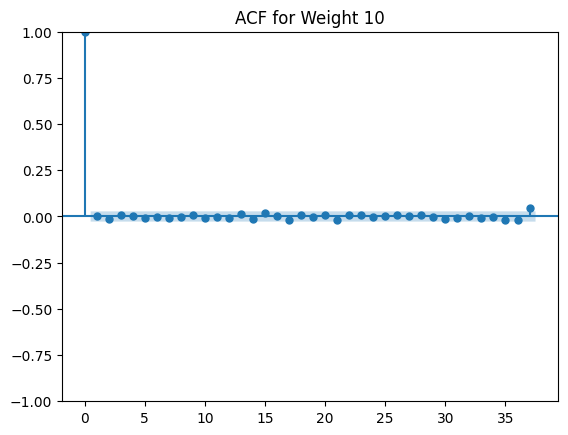

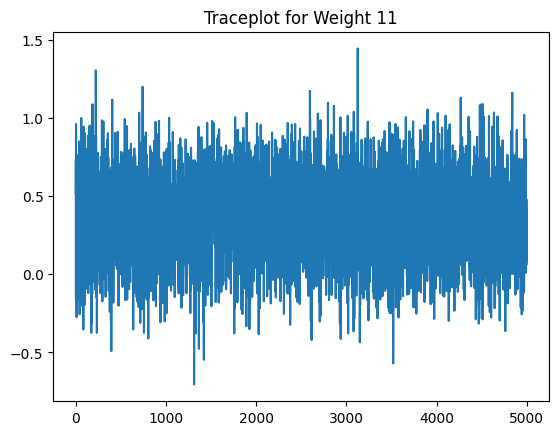

<Figure size 640x480 with 0 Axes>

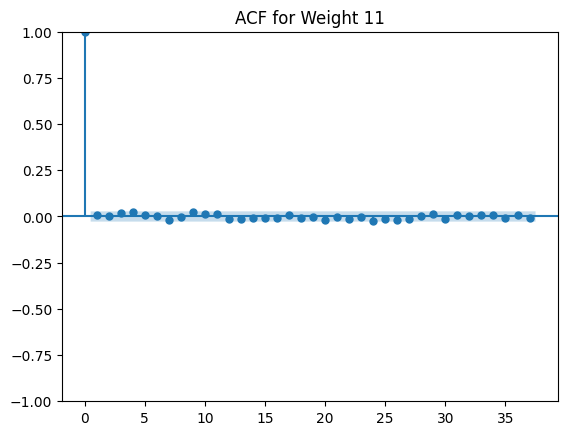

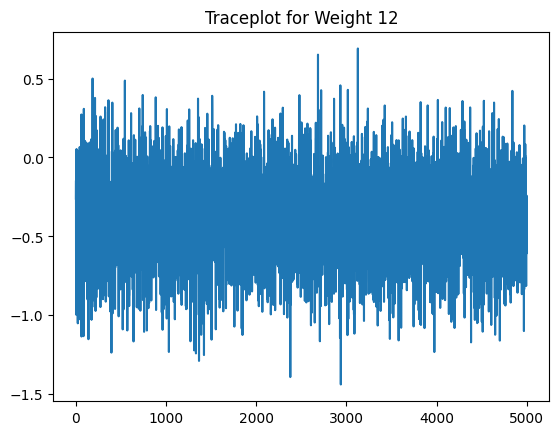

<Figure size 640x480 with 0 Axes>

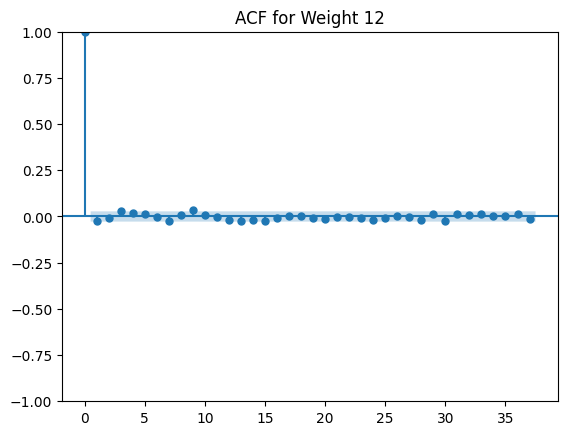

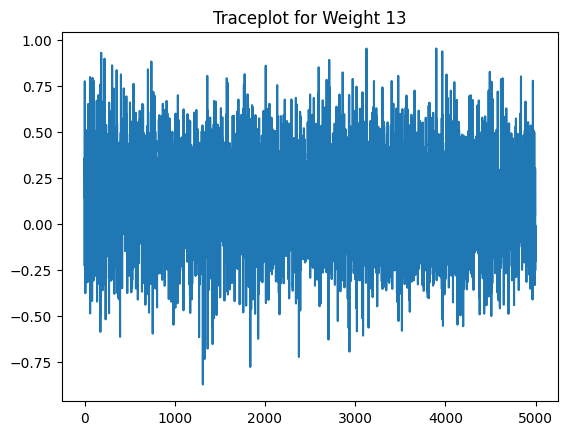

<Figure size 640x480 with 0 Axes>

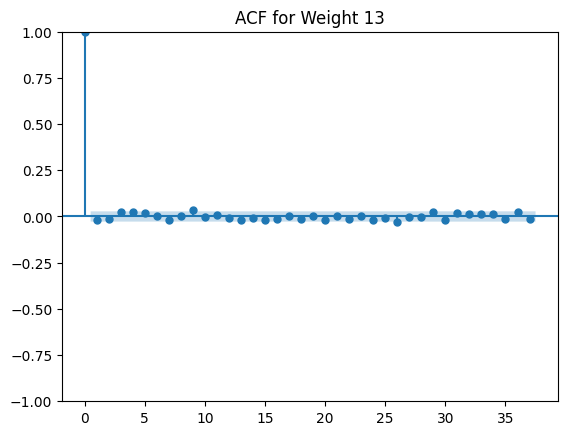

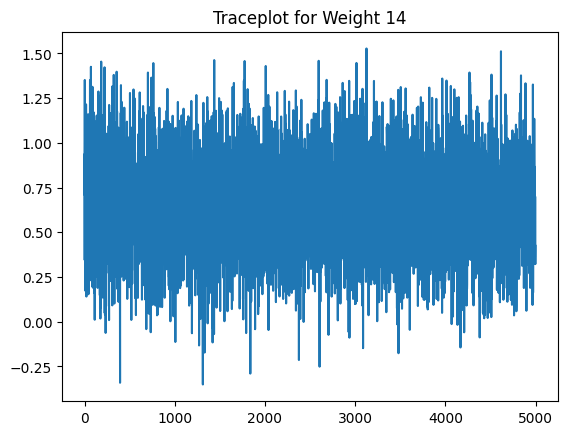

<Figure size 640x480 with 0 Axes>

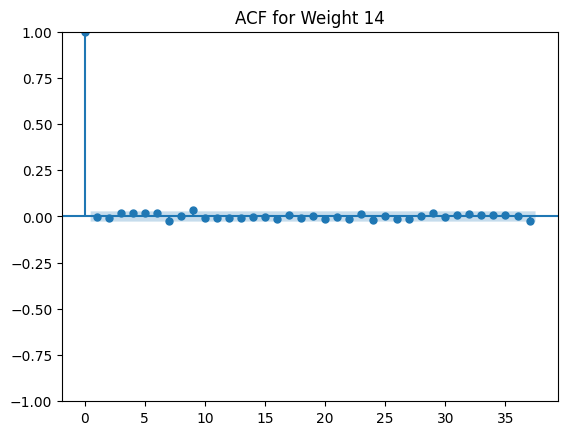

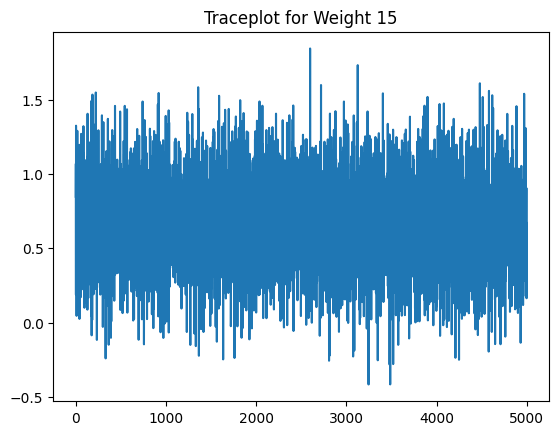

<Figure size 640x480 with 0 Axes>

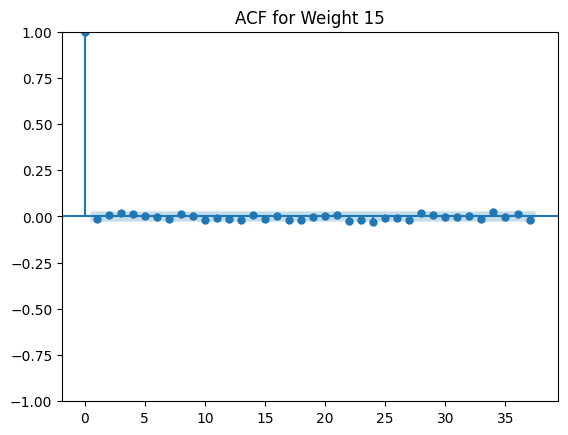

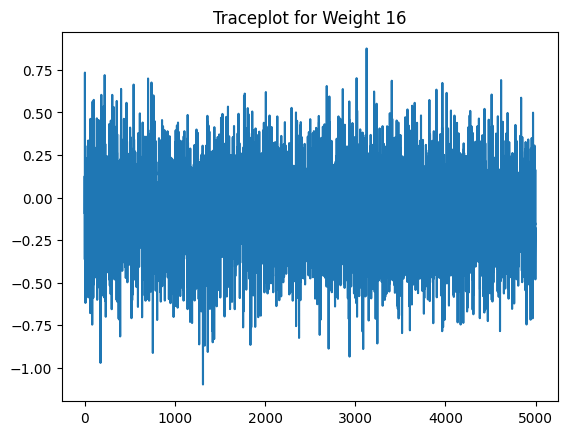

<Figure size 640x480 with 0 Axes>

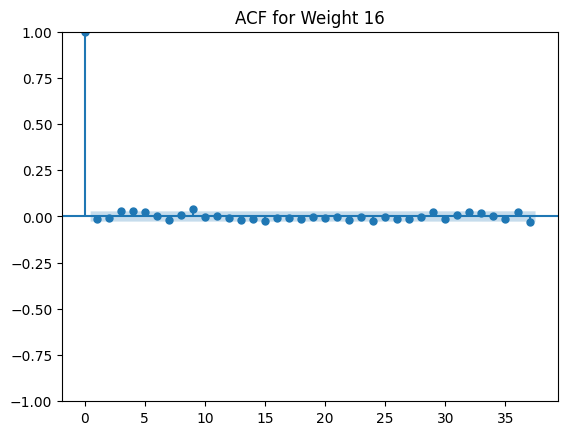

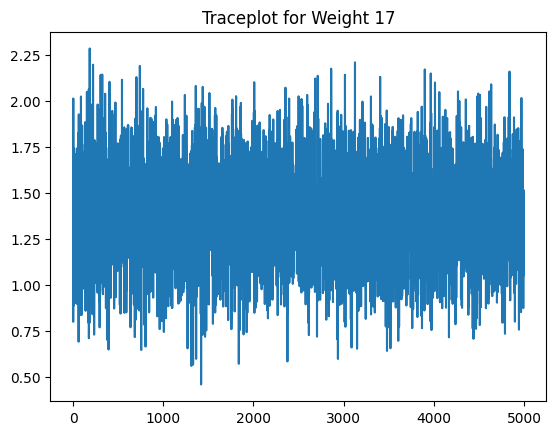

<Figure size 640x480 with 0 Axes>

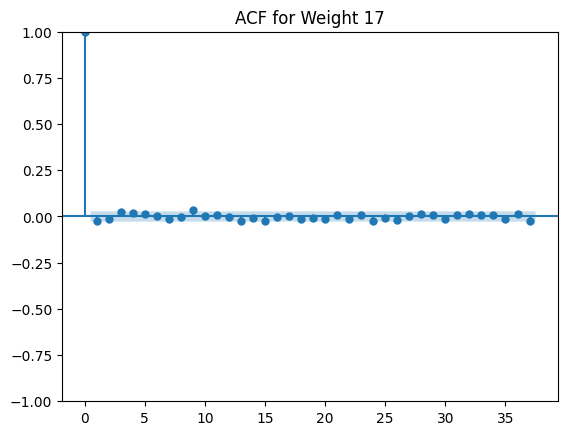

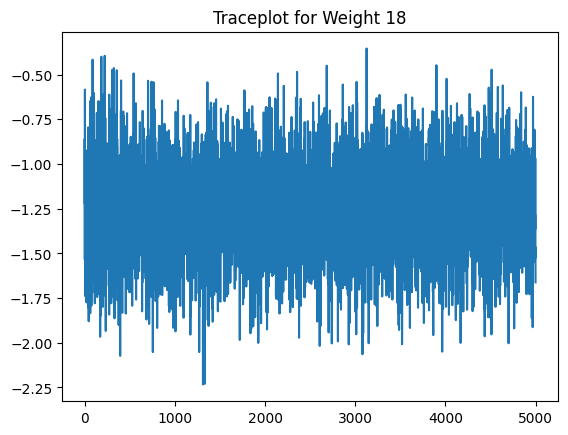

<Figure size 640x480 with 0 Axes>

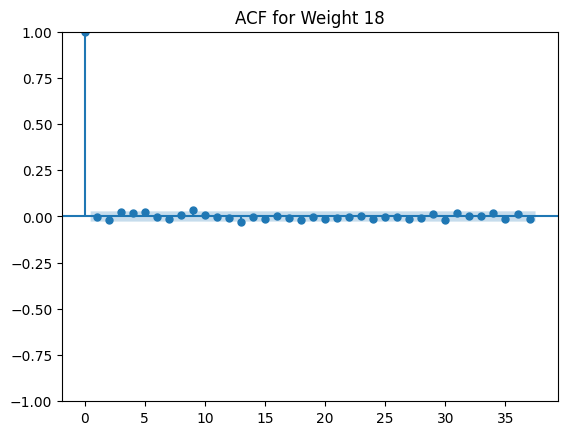

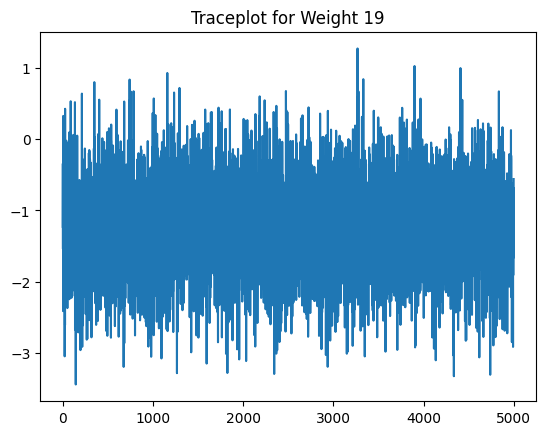

<Figure size 640x480 with 0 Axes>

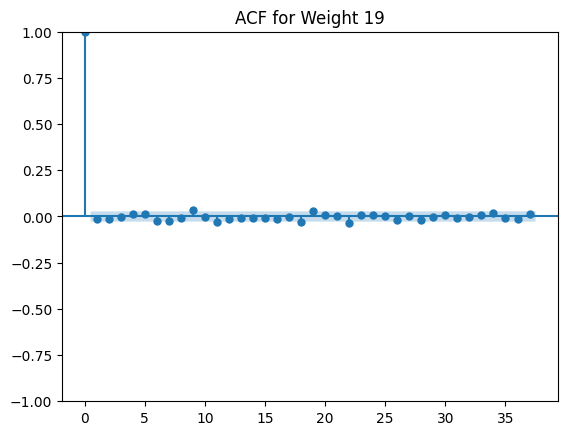

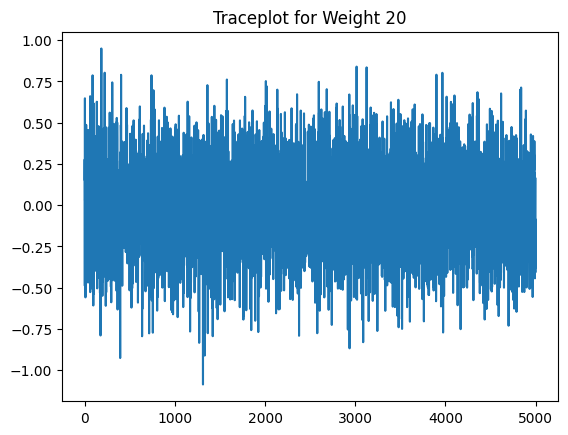

<Figure size 640x480 with 0 Axes>

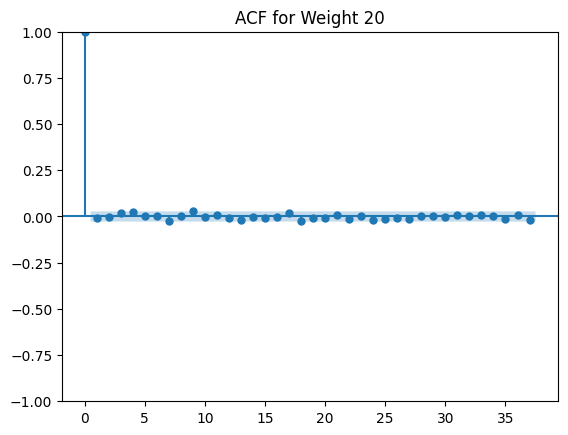

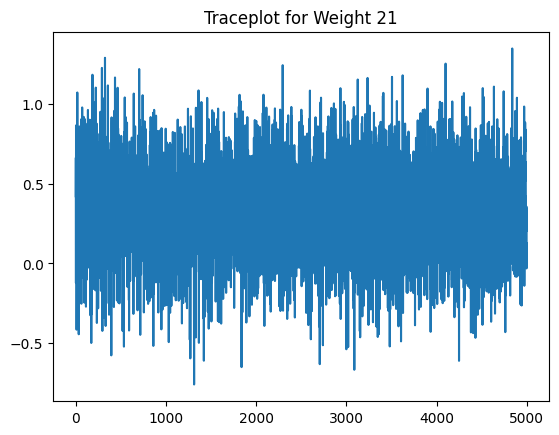

<Figure size 640x480 with 0 Axes>

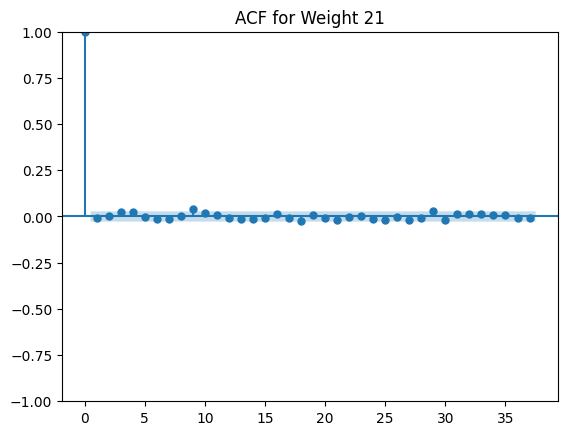

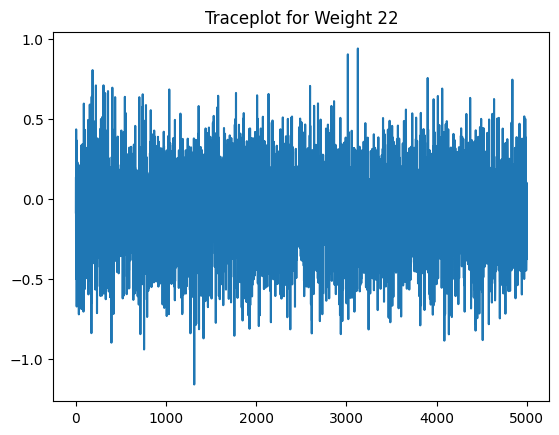

<Figure size 640x480 with 0 Axes>

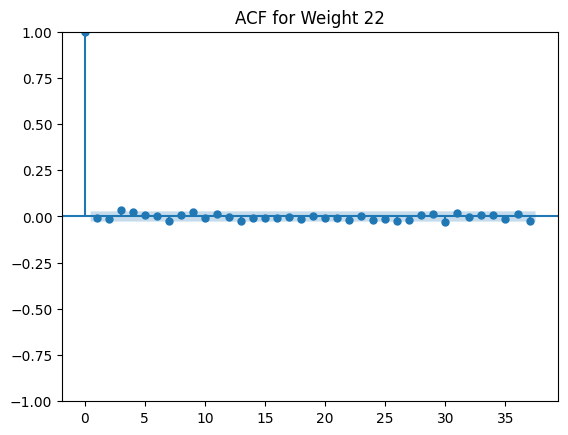

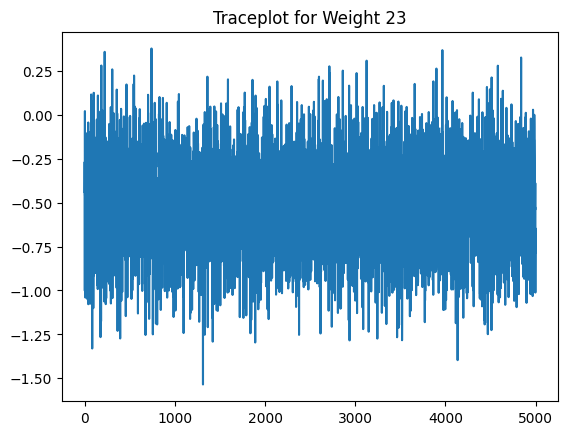

<Figure size 640x480 with 0 Axes>

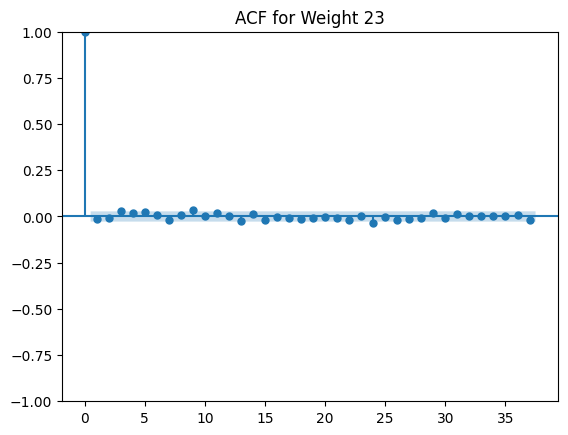

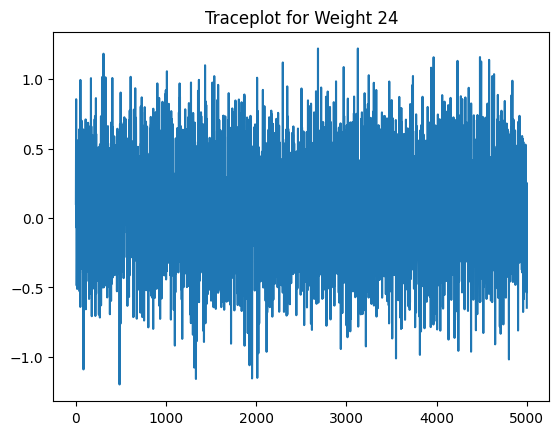

<Figure size 640x480 with 0 Axes>

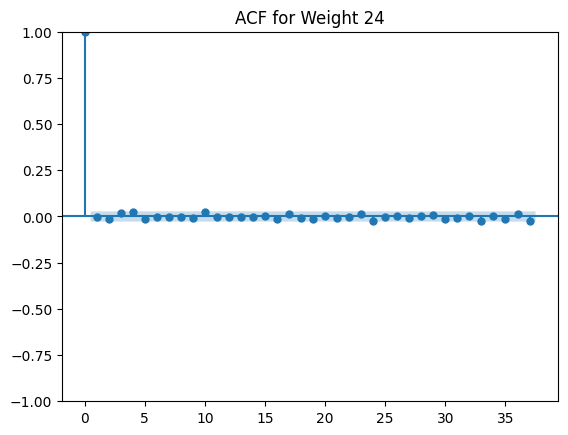

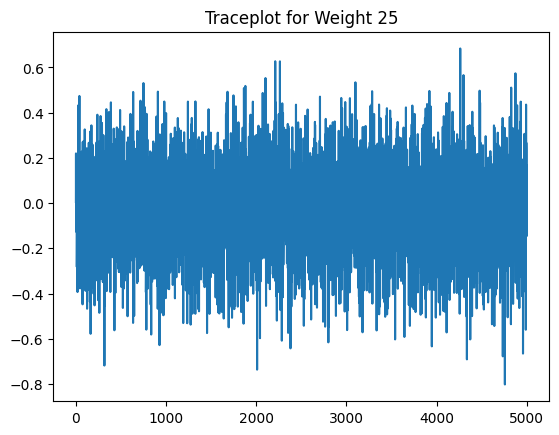

<Figure size 640x480 with 0 Axes>

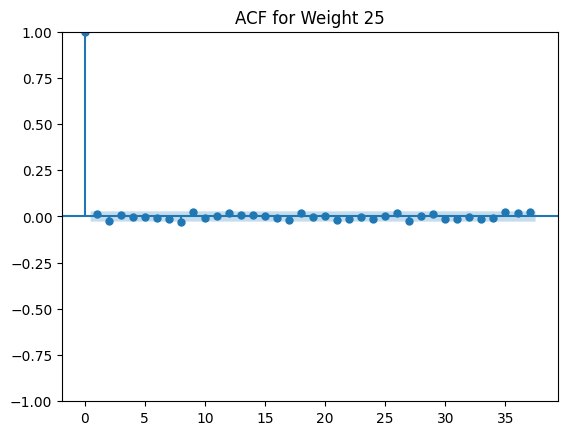

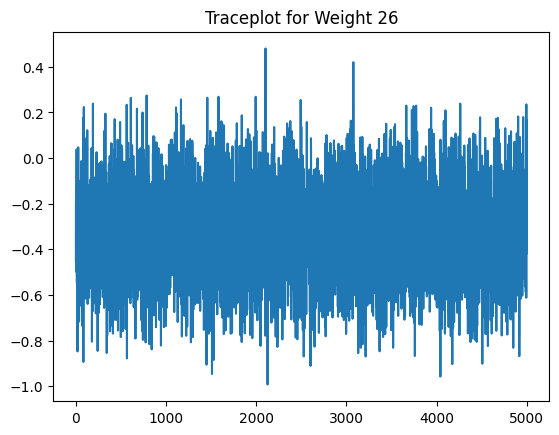

<Figure size 640x480 with 0 Axes>

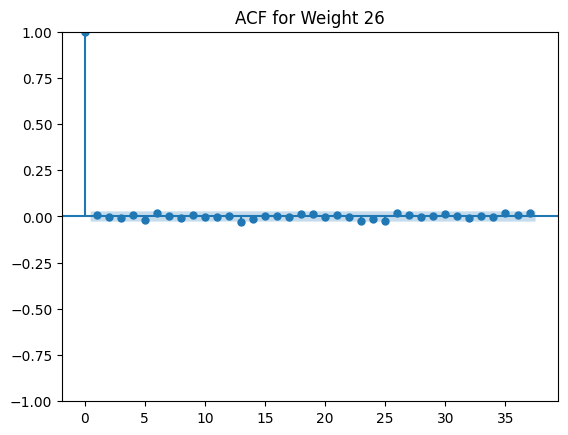

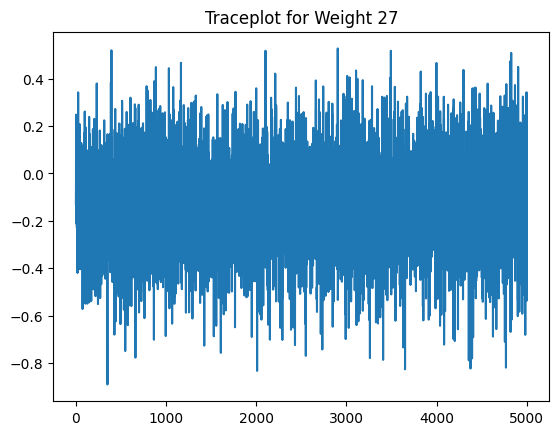

<Figure size 640x480 with 0 Axes>

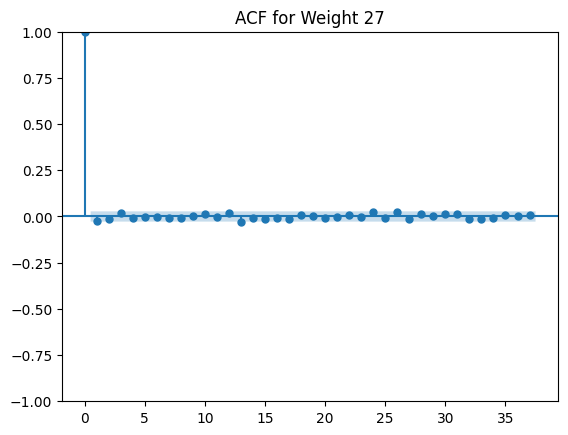

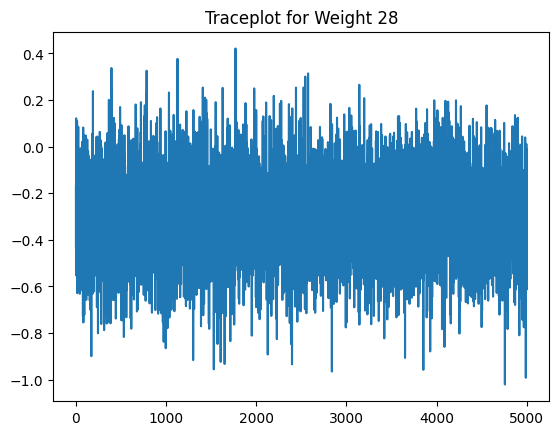

<Figure size 640x480 with 0 Axes>

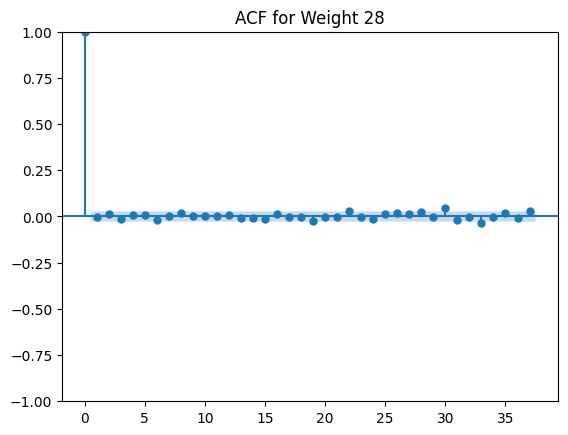

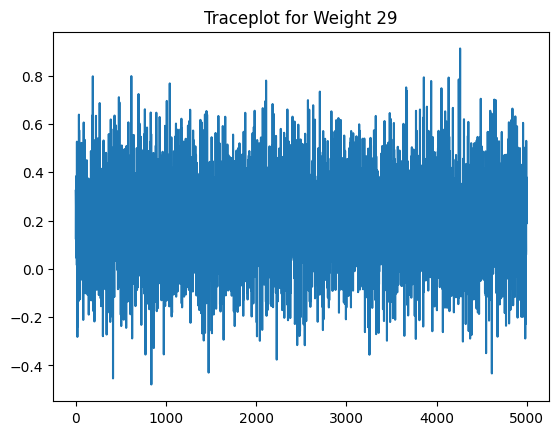

<Figure size 640x480 with 0 Axes>

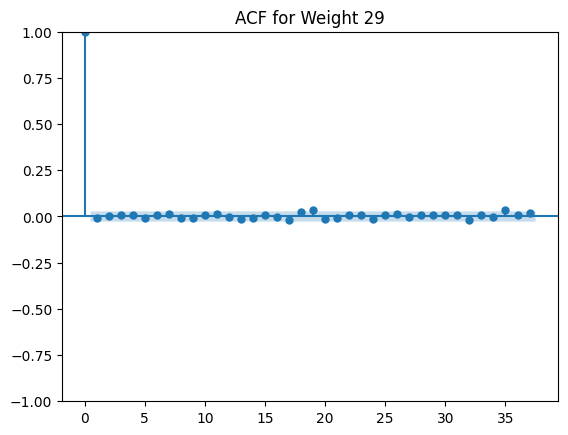

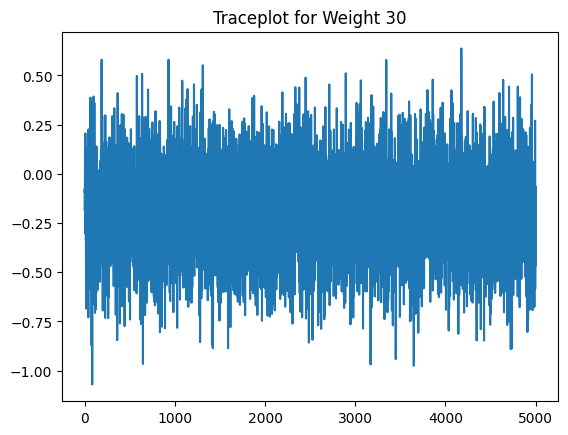

<Figure size 640x480 with 0 Axes>

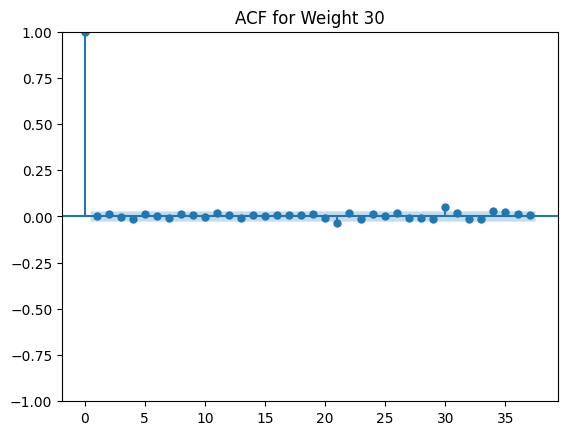

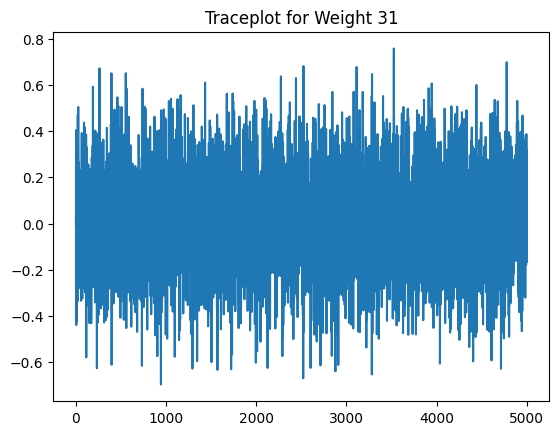

<Figure size 640x480 with 0 Axes>

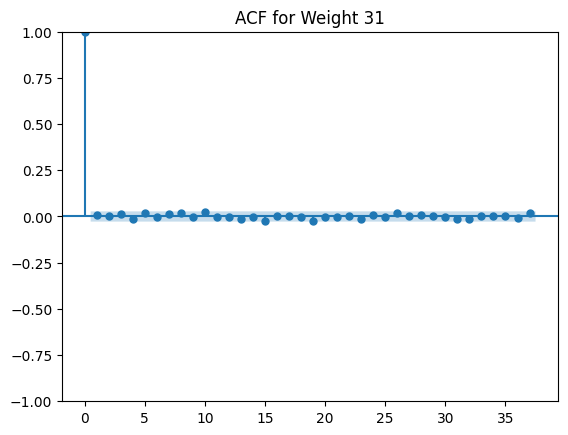

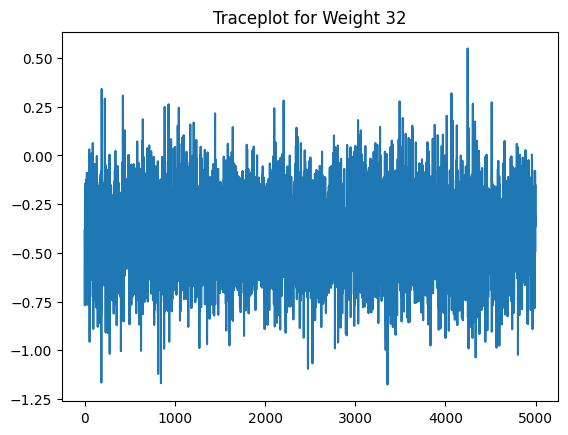

<Figure size 640x480 with 0 Axes>

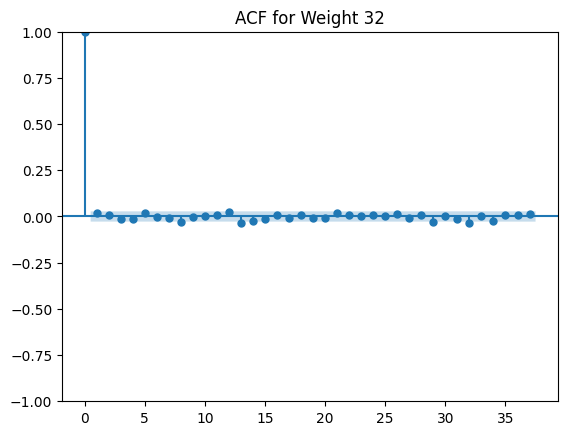

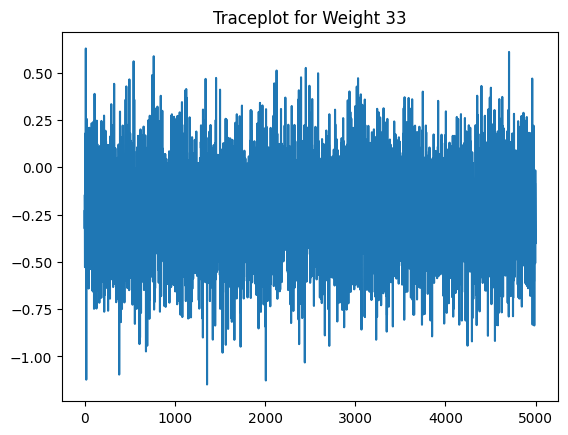

<Figure size 640x480 with 0 Axes>

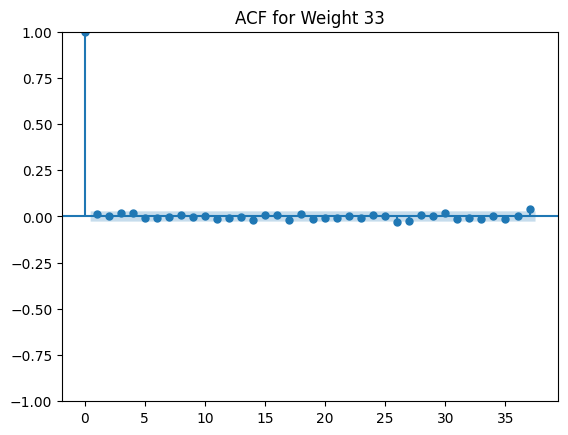

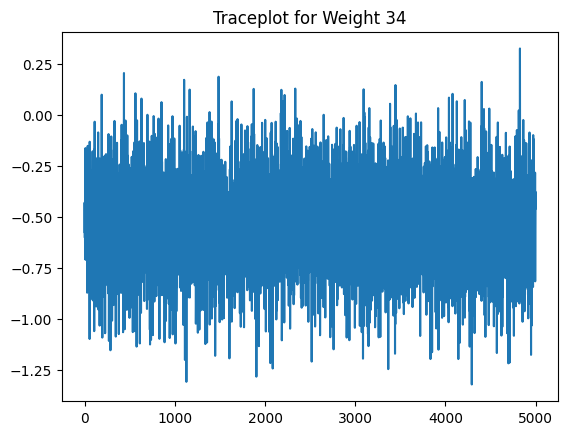

<Figure size 640x480 with 0 Axes>

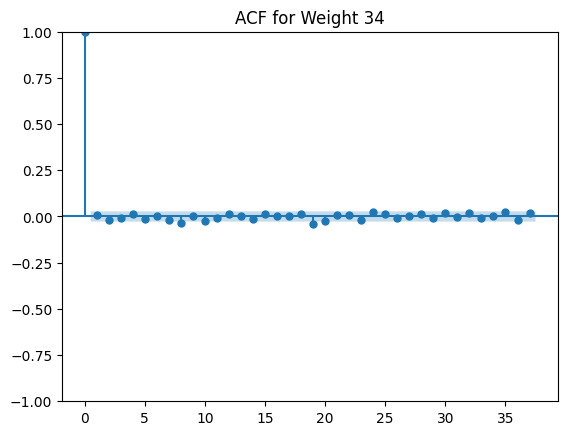

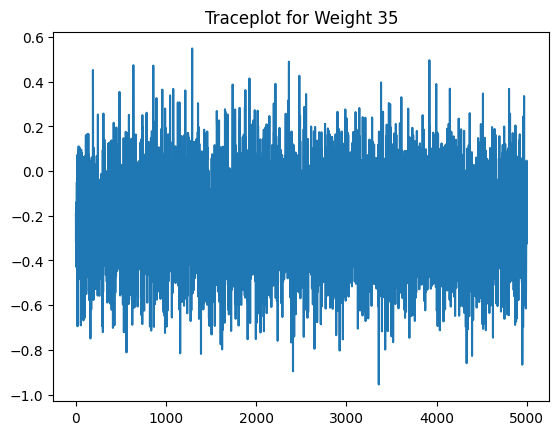

<Figure size 640x480 with 0 Axes>

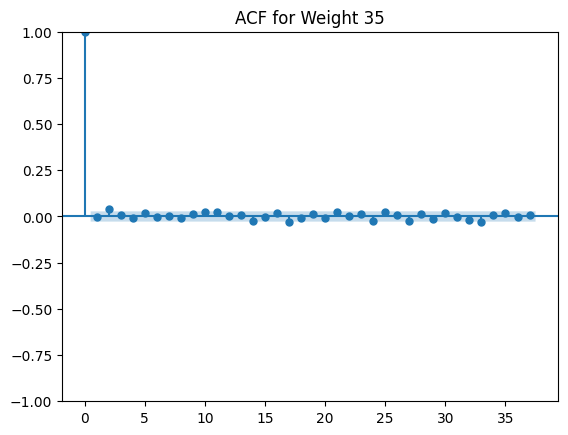

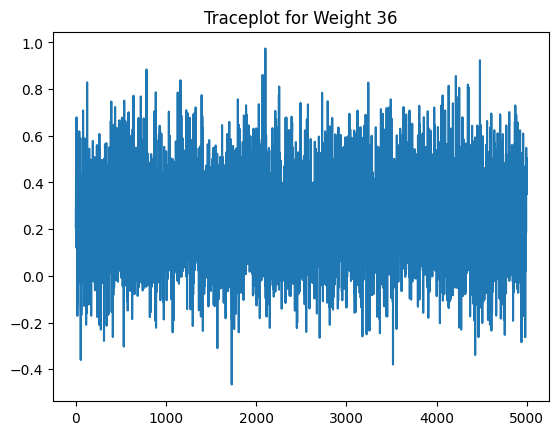

<Figure size 640x480 with 0 Axes>

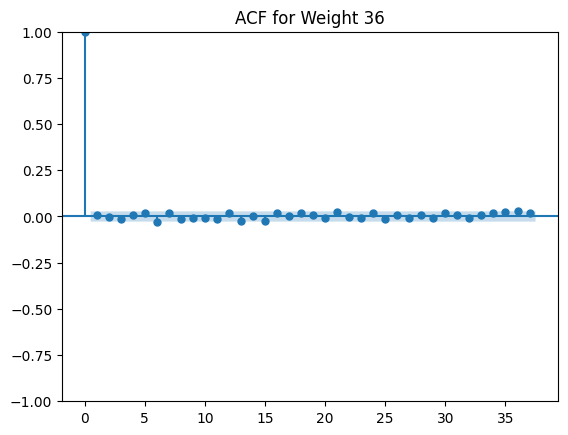

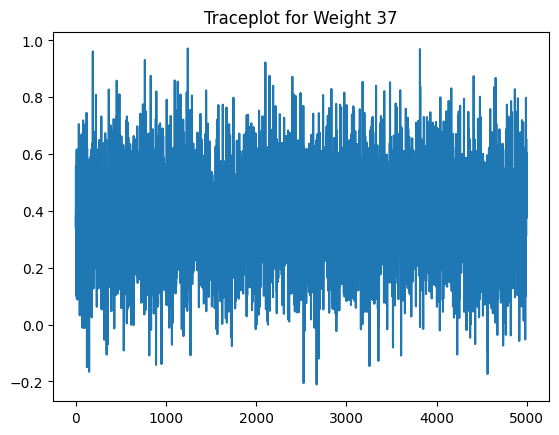

<Figure size 640x480 with 0 Axes>

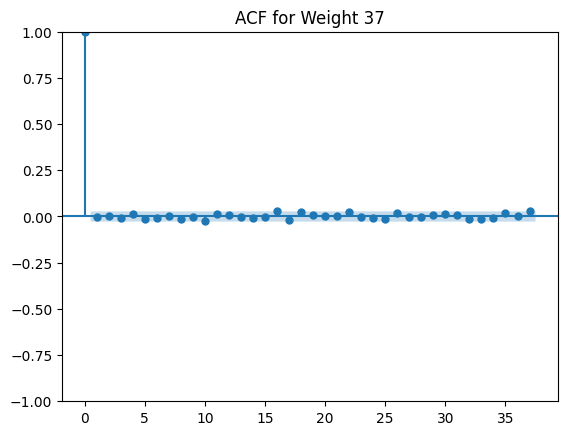

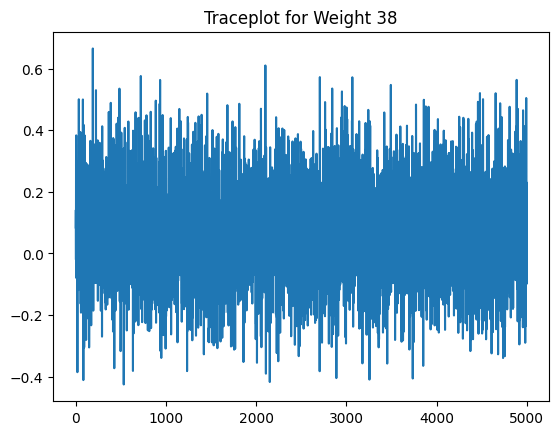

<Figure size 640x480 with 0 Axes>

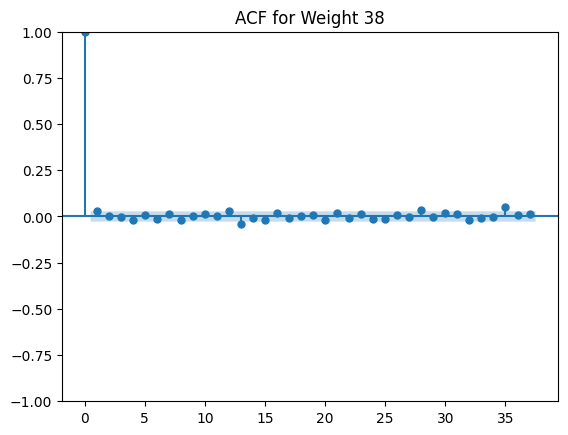

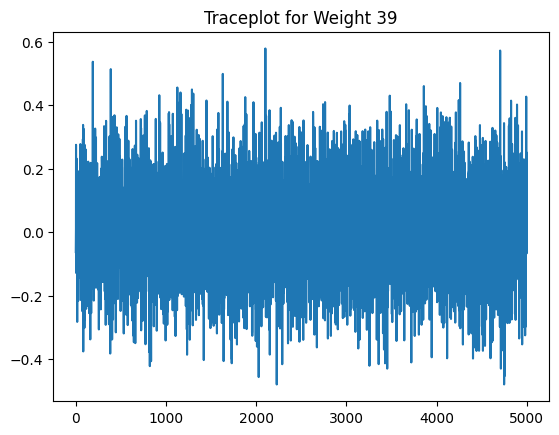

<Figure size 640x480 with 0 Axes>

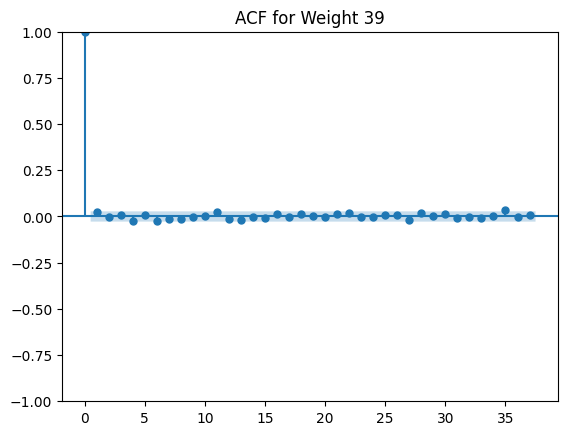

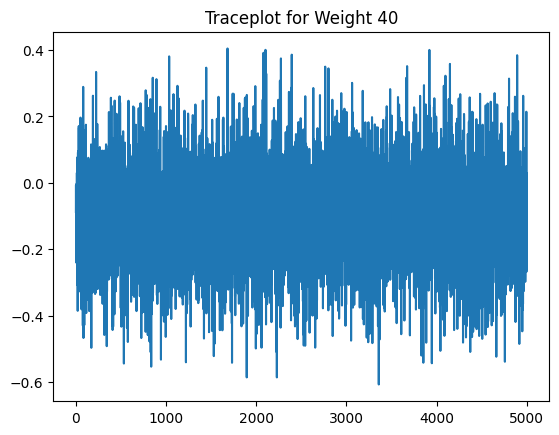

<Figure size 640x480 with 0 Axes>

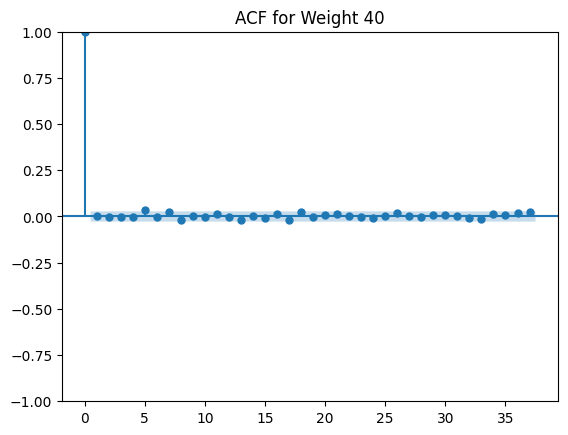

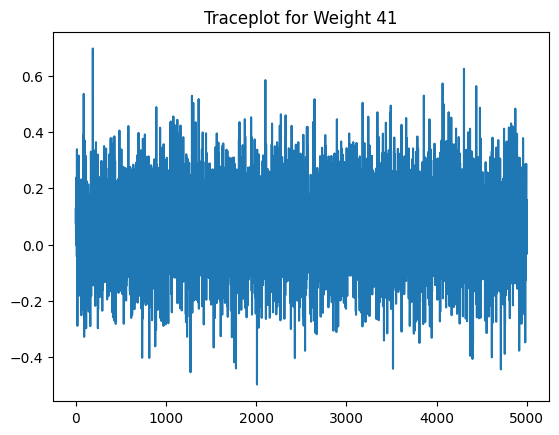

<Figure size 640x480 with 0 Axes>

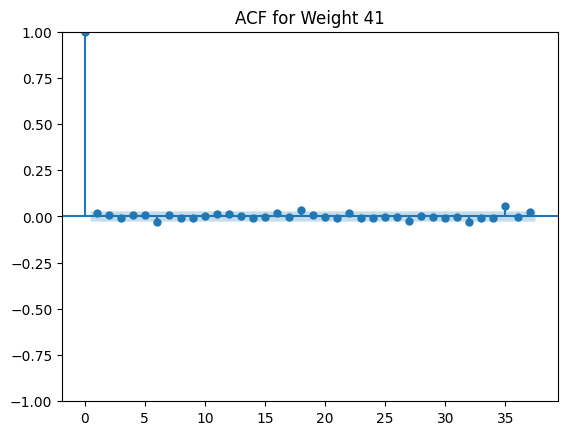

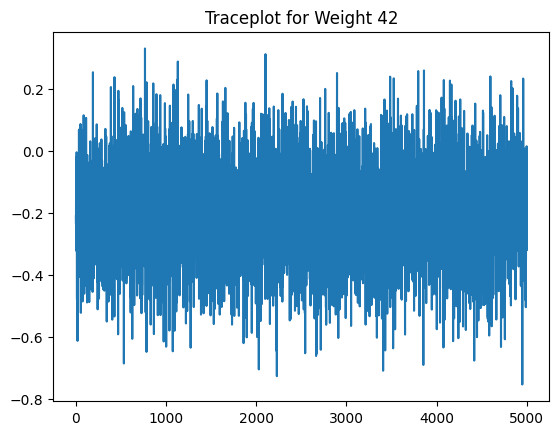

<Figure size 640x480 with 0 Axes>

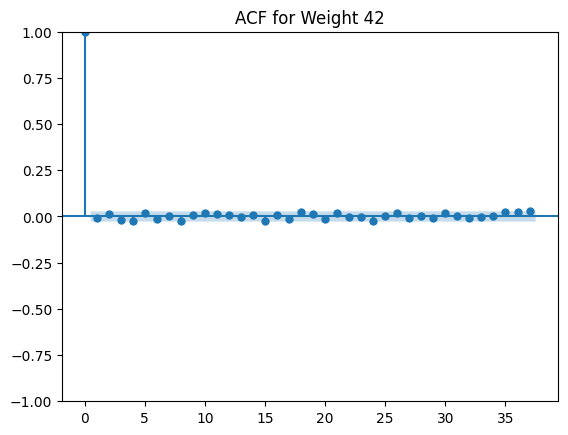

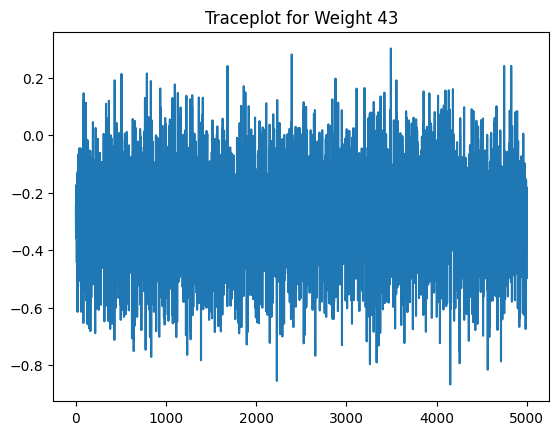

<Figure size 640x480 with 0 Axes>

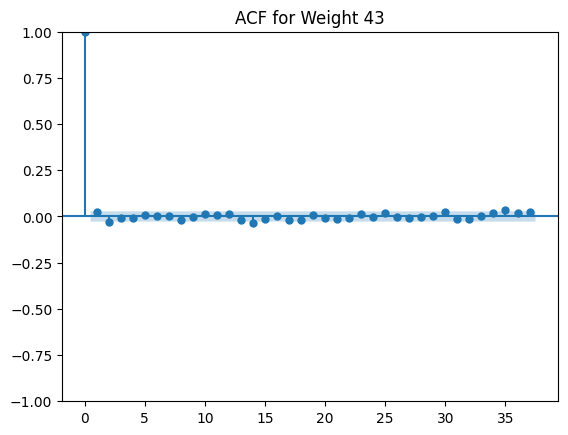

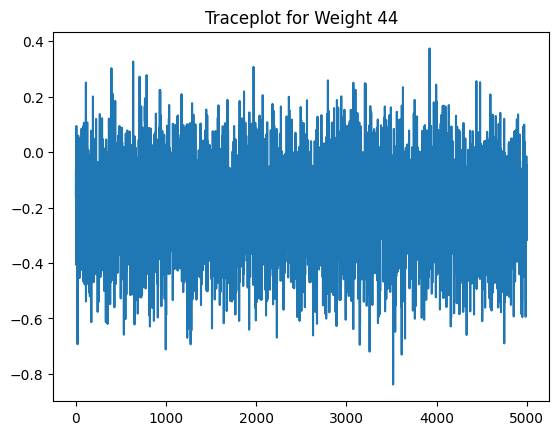

<Figure size 640x480 with 0 Axes>

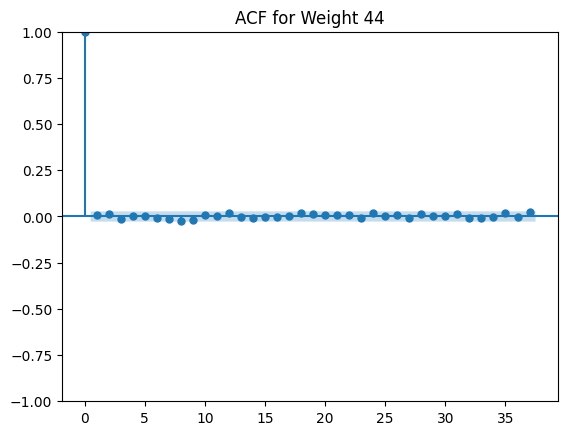

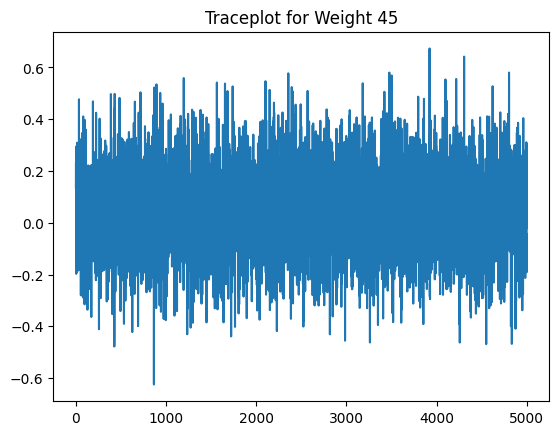

<Figure size 640x480 with 0 Axes>

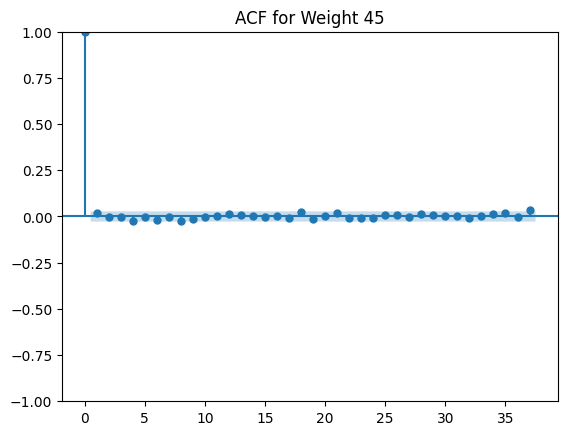

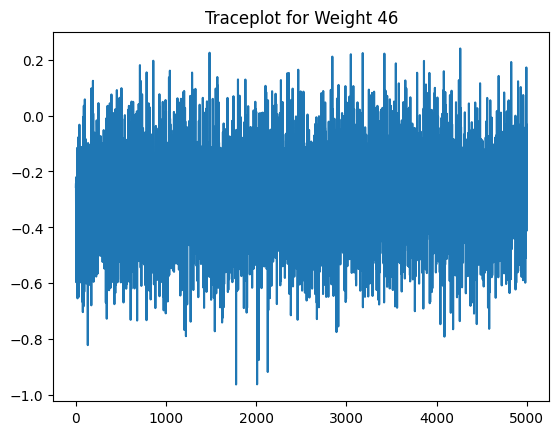

<Figure size 640x480 with 0 Axes>

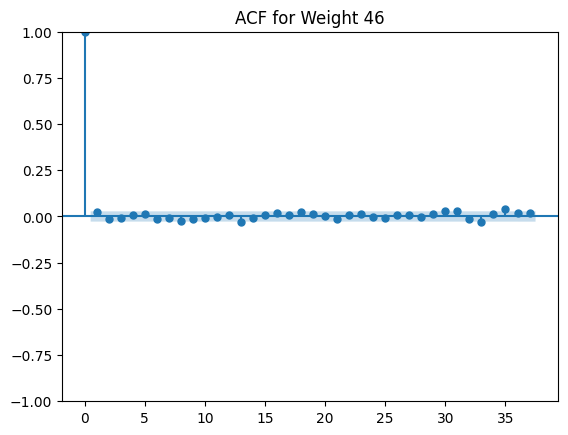

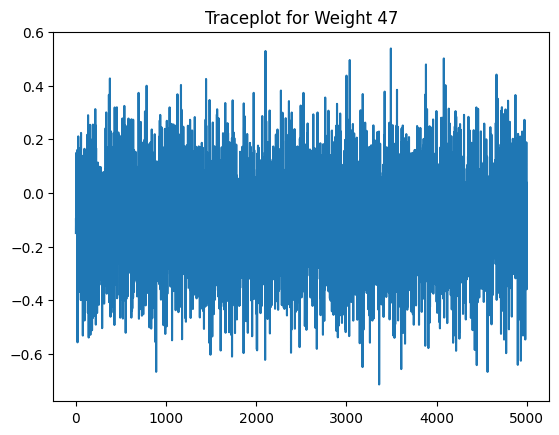

<Figure size 640x480 with 0 Axes>

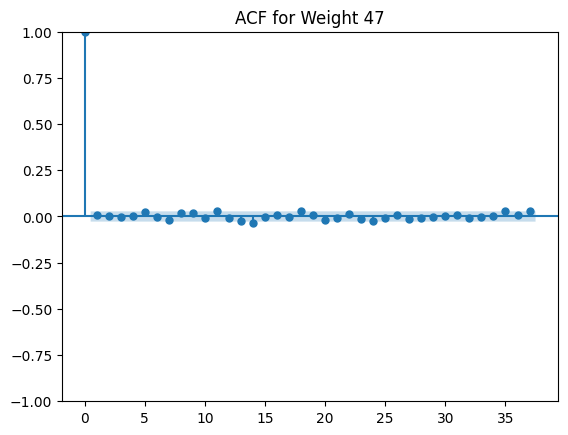

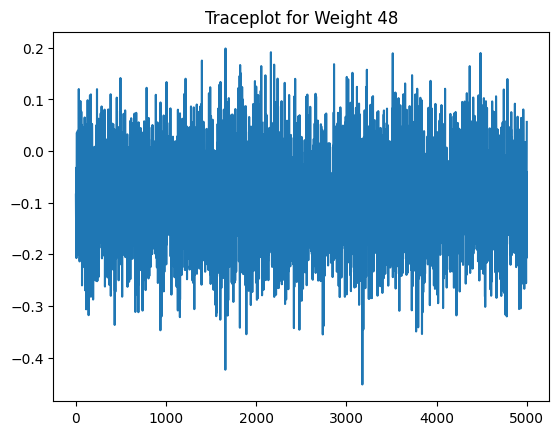

<Figure size 640x480 with 0 Axes>

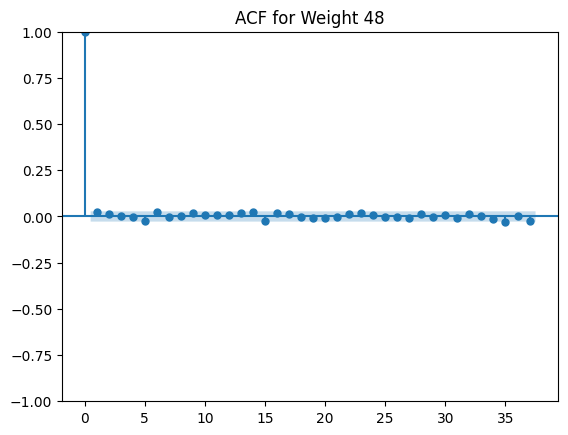

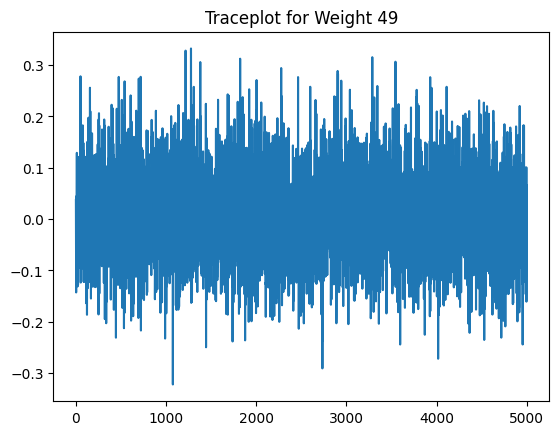

<Figure size 640x480 with 0 Axes>

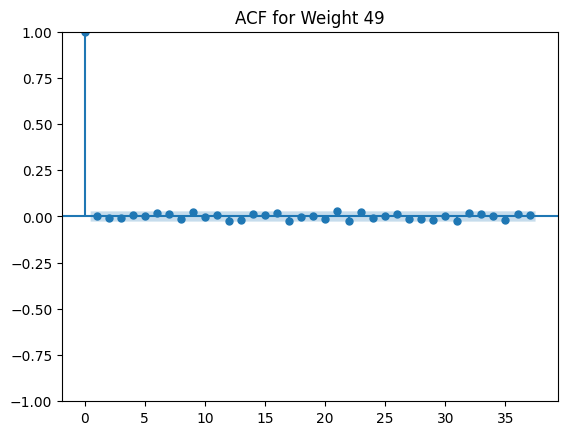

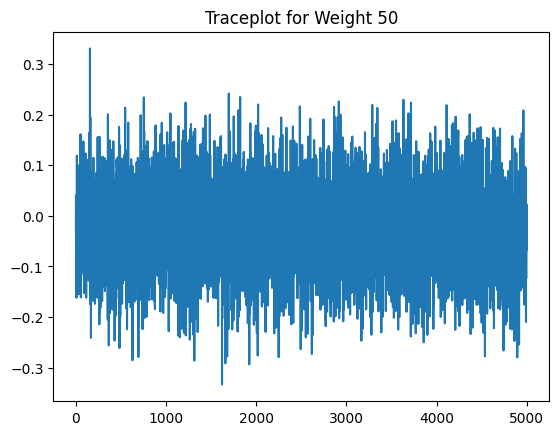

<Figure size 640x480 with 0 Axes>

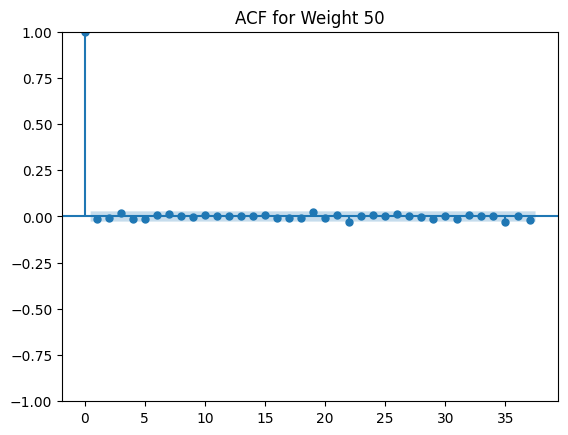

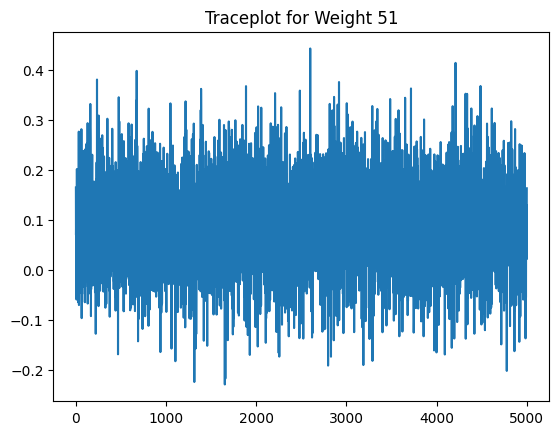

<Figure size 640x480 with 0 Axes>

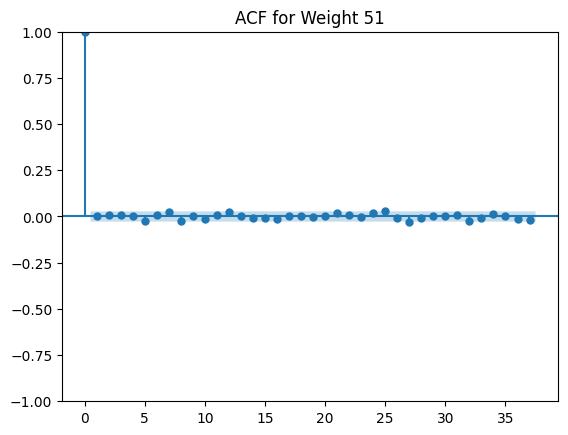

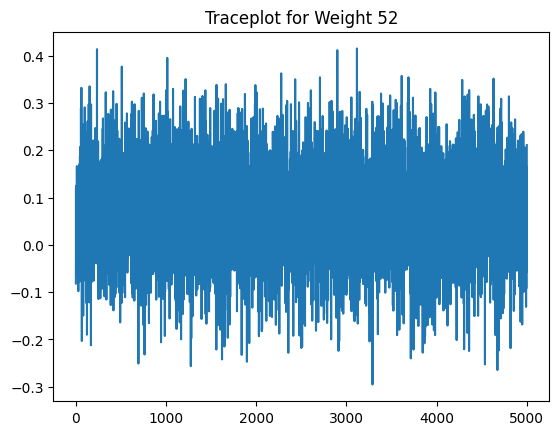

<Figure size 640x480 with 0 Axes>

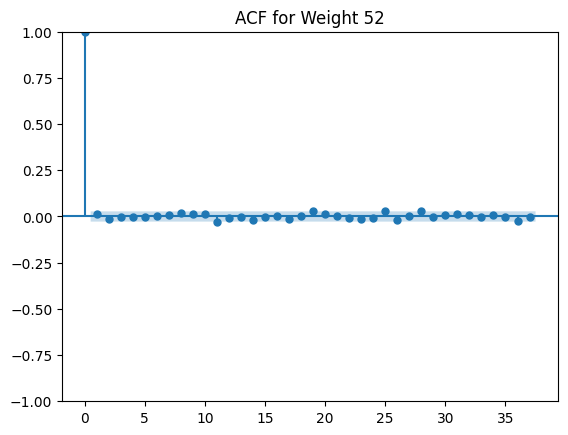

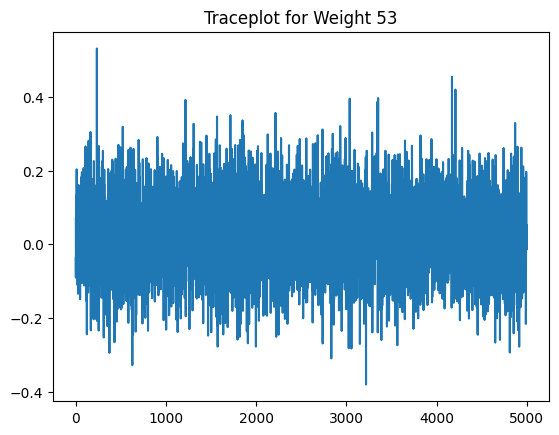

<Figure size 640x480 with 0 Axes>

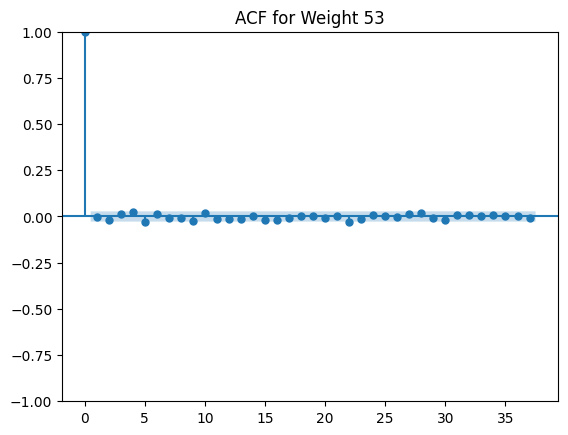

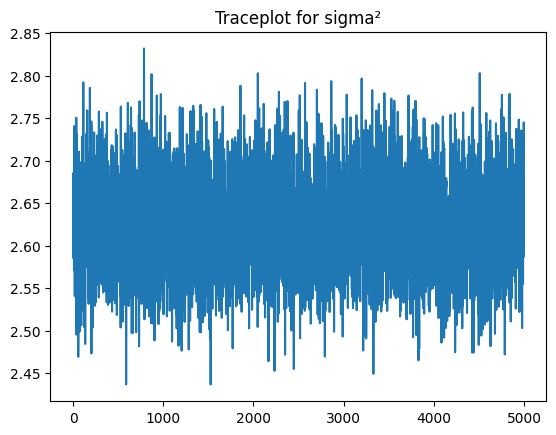

<Figure size 640x480 with 0 Axes>

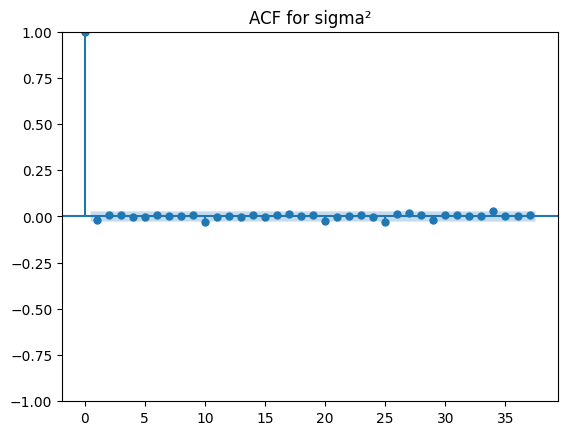

In [60]:
# Traceplots and ACF for weights
for i in range(p):
  # Plot the traceplot of the i-th weight
  plt.figure()
  plt.plot(gibbs_samples_w[:, i])
  plt.title(f"Traceplot for Weight {i}")
  plt.show()

  # Plot the ACF of the i-th weight
  plt.figure()
  plot_acf(gibbs_samples_w[:, i])
  plt.title(f"ACF for Weight {i}")
  plt.show()

  print() # Separation for format

# Traceplot of variance term
plt.figure()
plt.plot(gibbs_samples_sigmay)
plt.title("Traceplot for sigma²")
plt.show()

# ACF of variance term
plt.figure()
plot_acf(gibbs_samples_sigmay)
plt.title("ACF for sigma²")
plt.show()

### Estimated Posterior Distributions

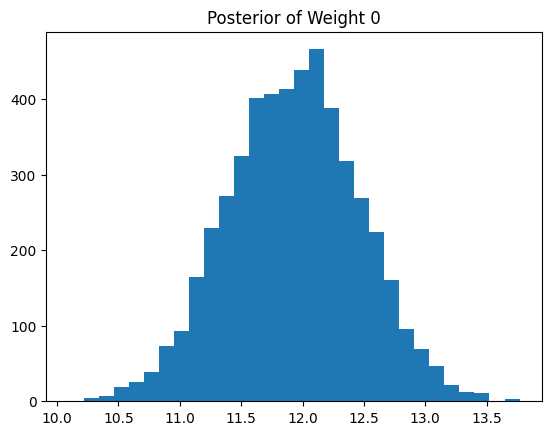

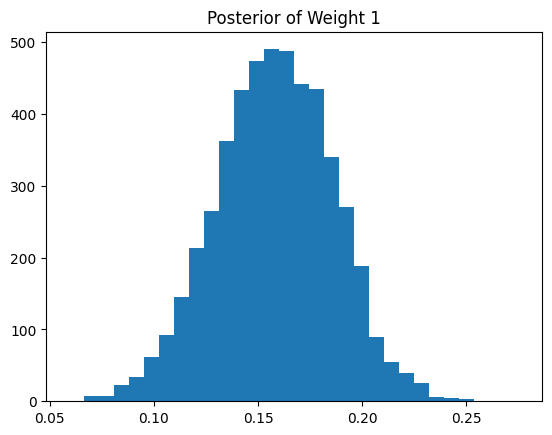

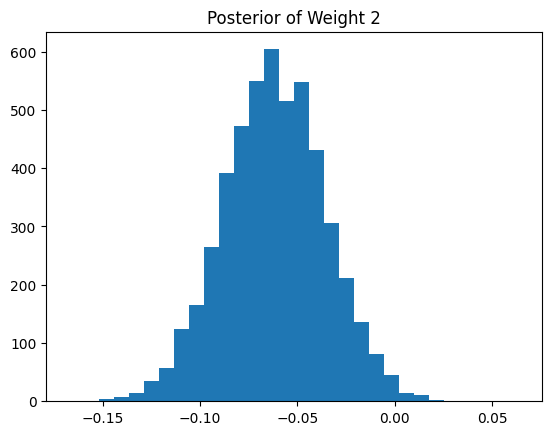

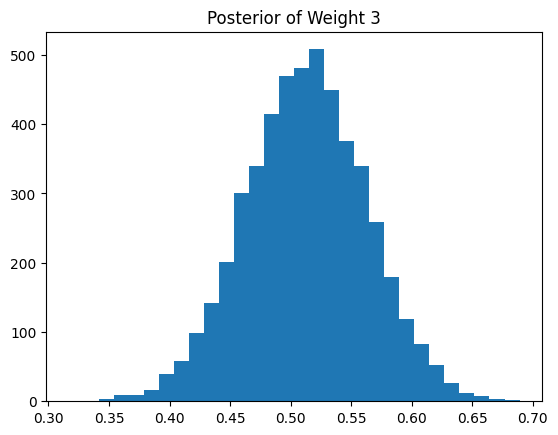

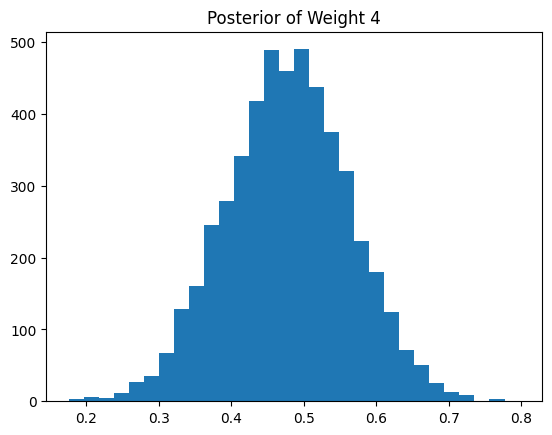

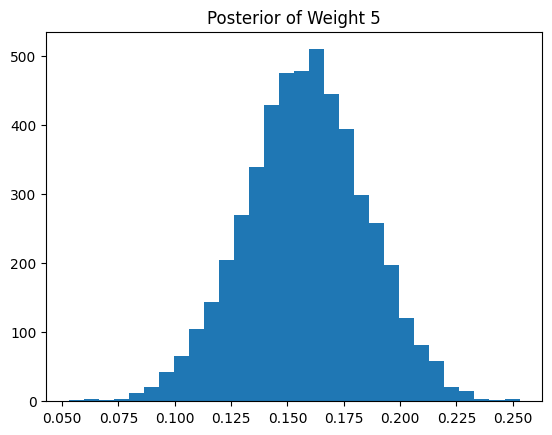

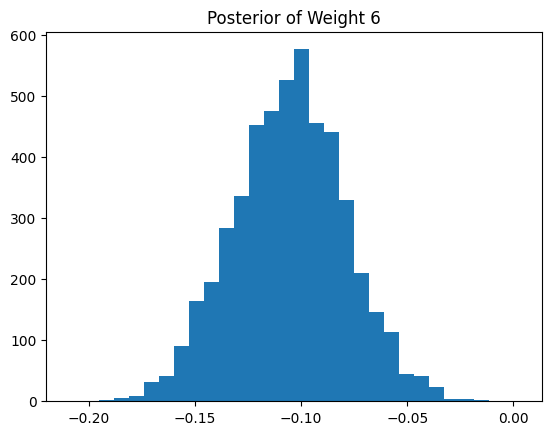

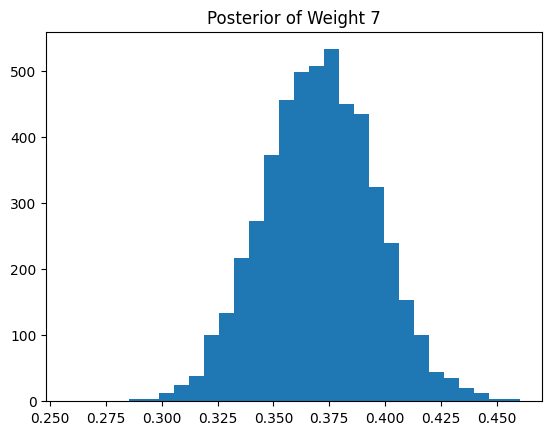

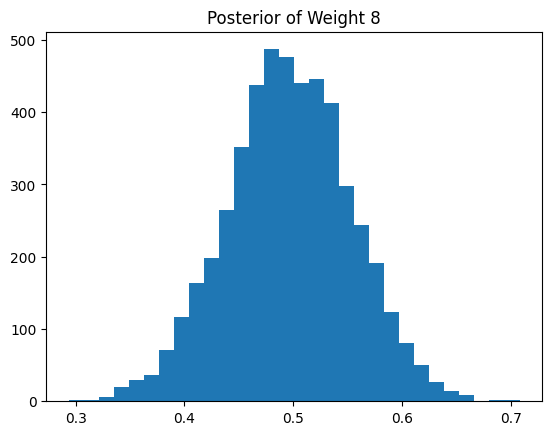

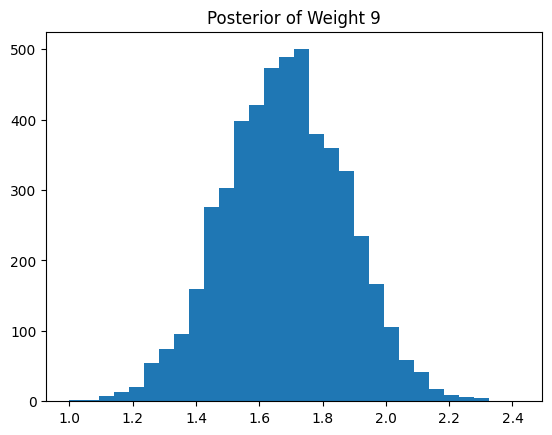

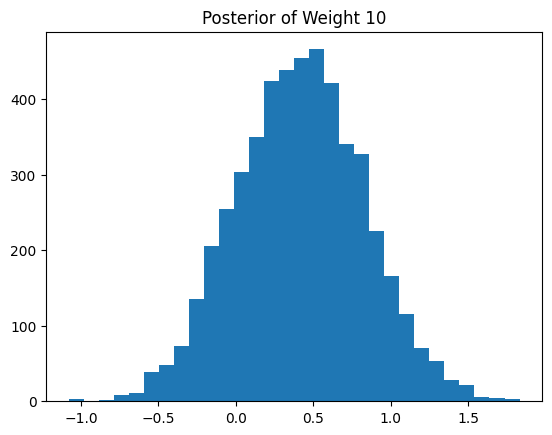

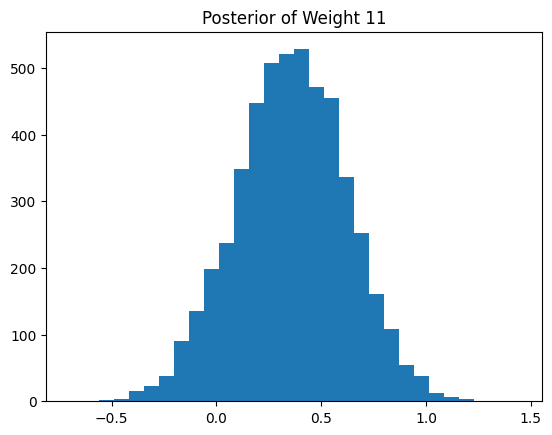

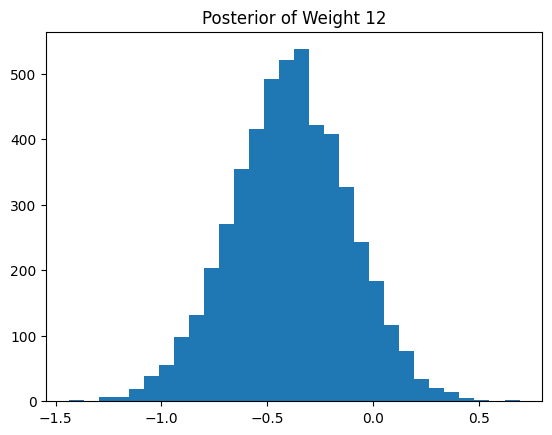

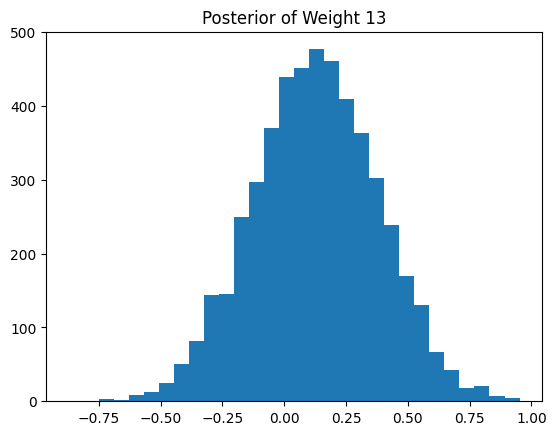

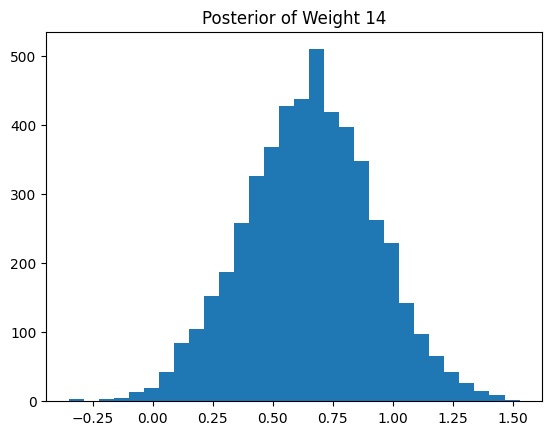

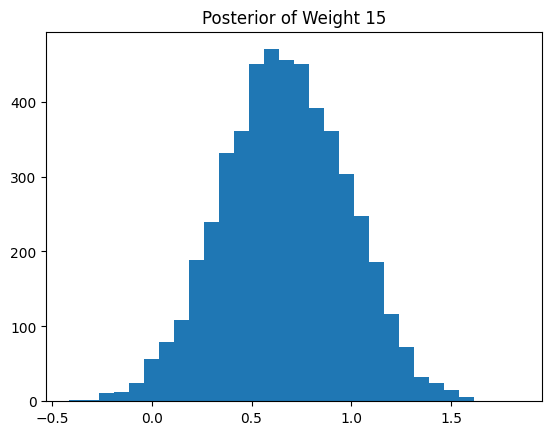

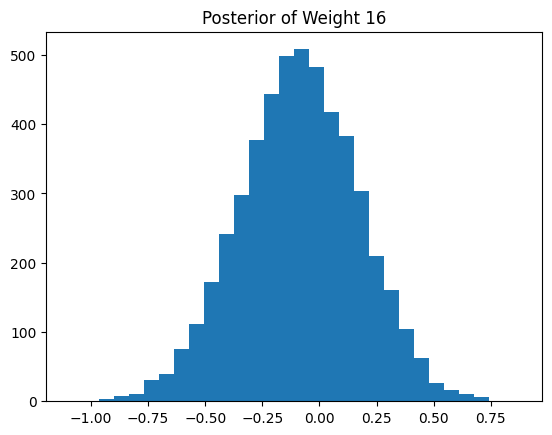

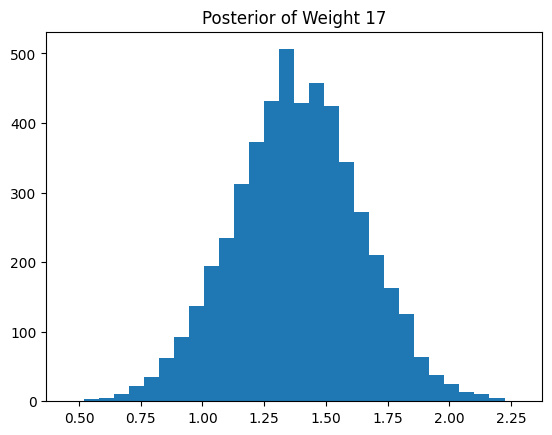

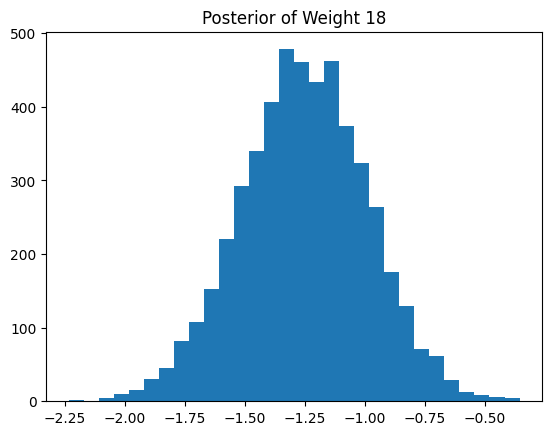

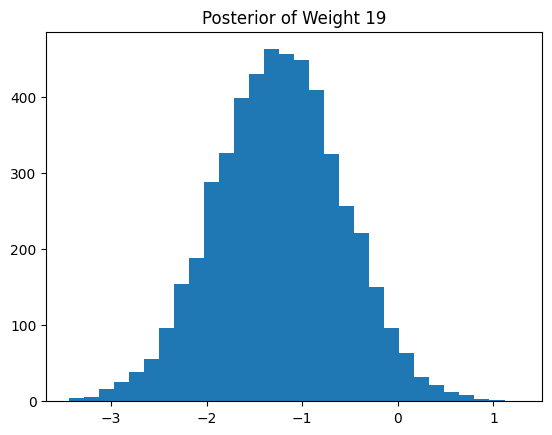

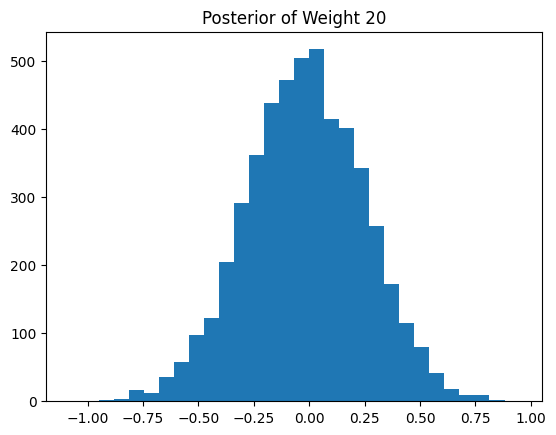

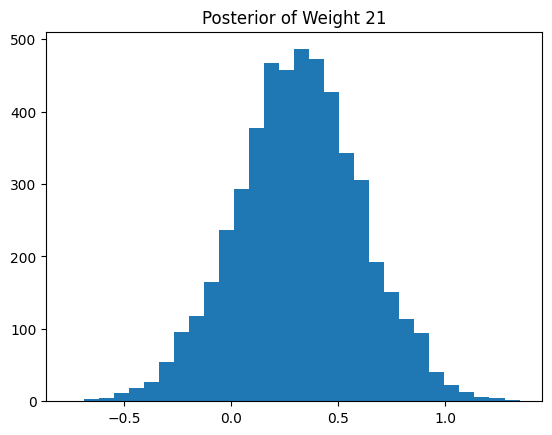

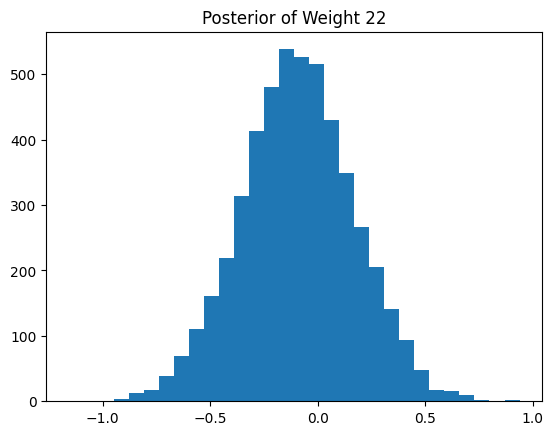

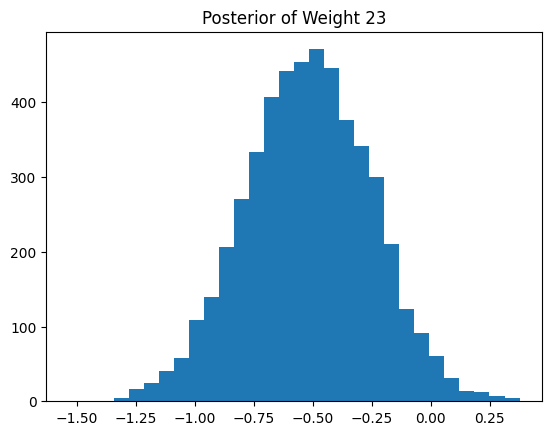

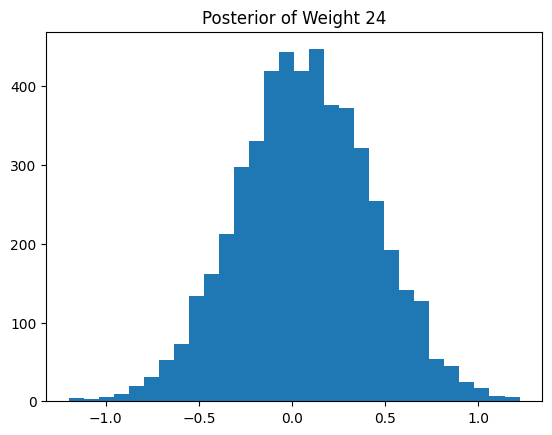

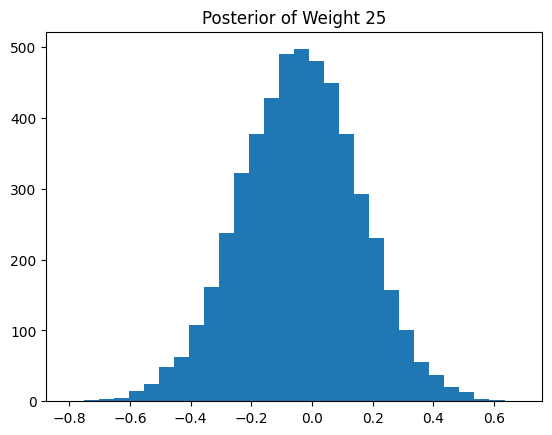

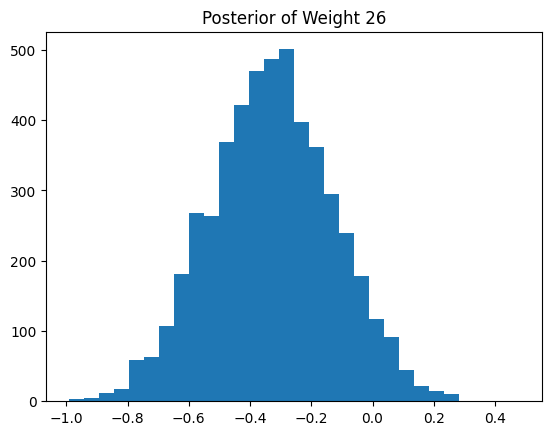

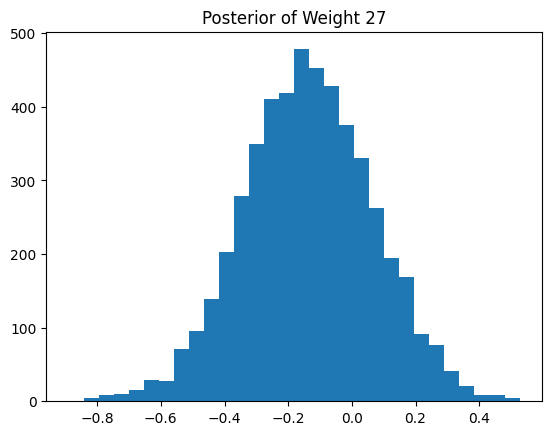

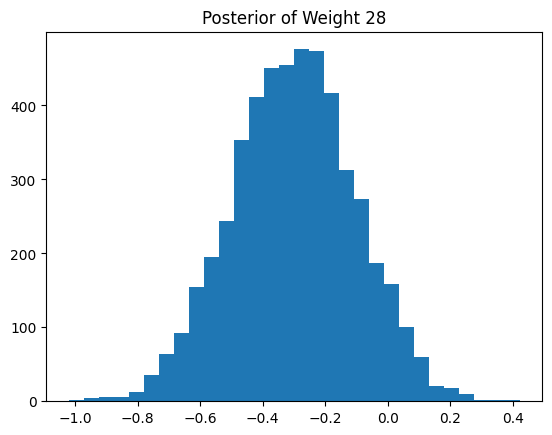

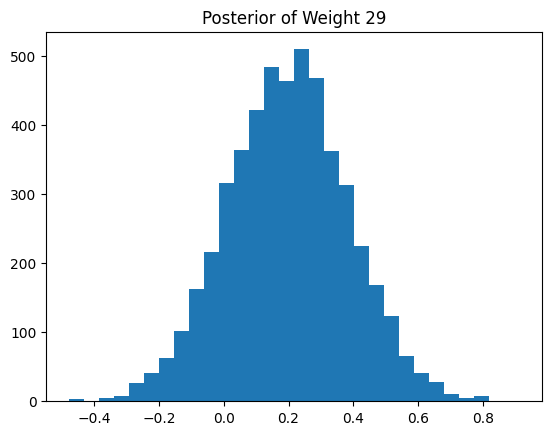

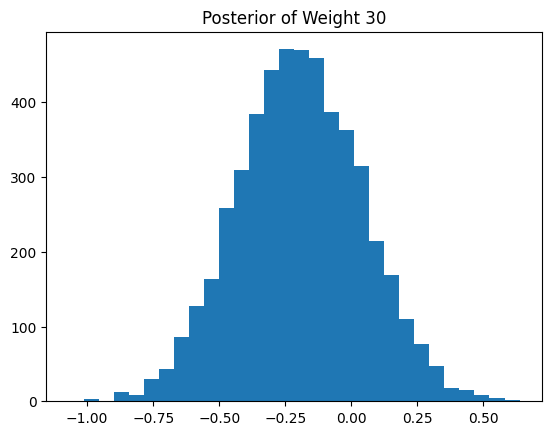

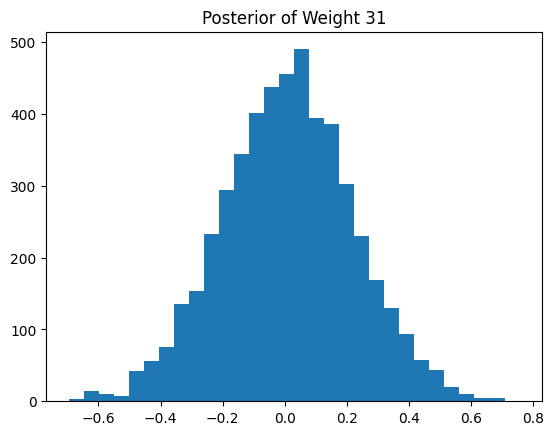

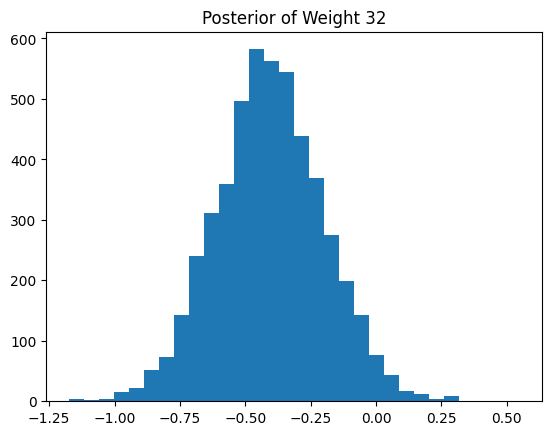

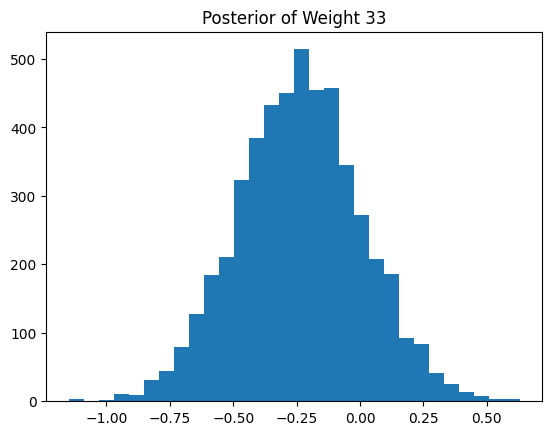

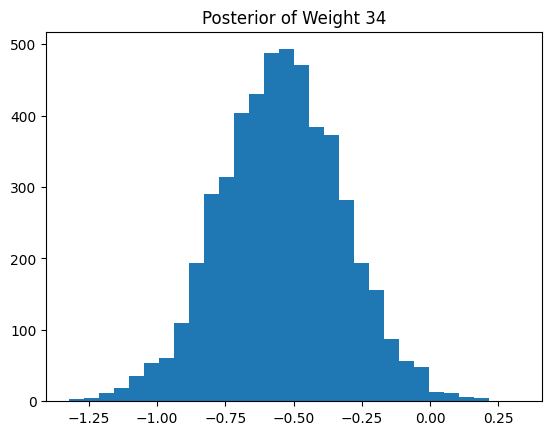

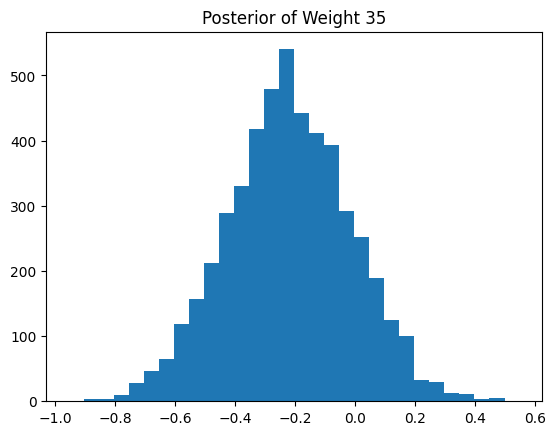

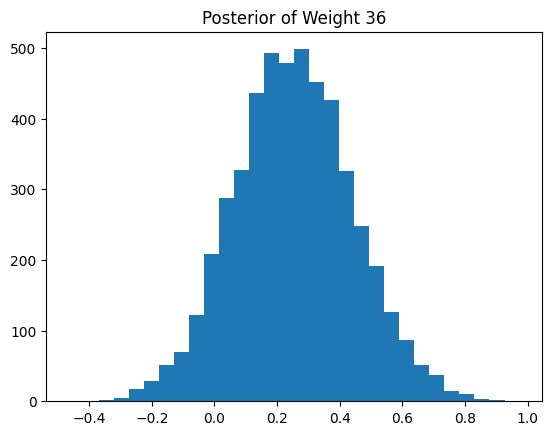

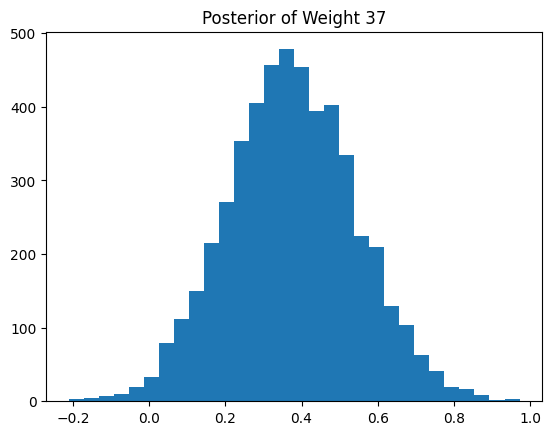

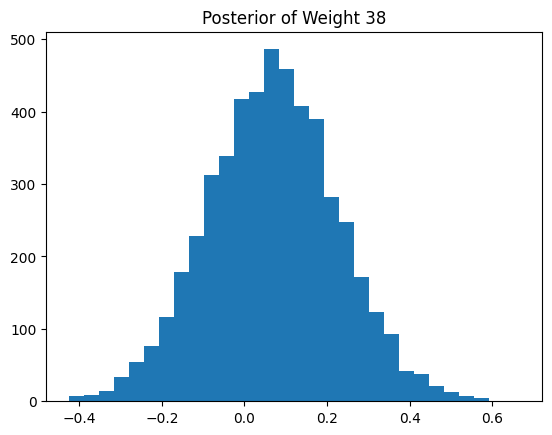

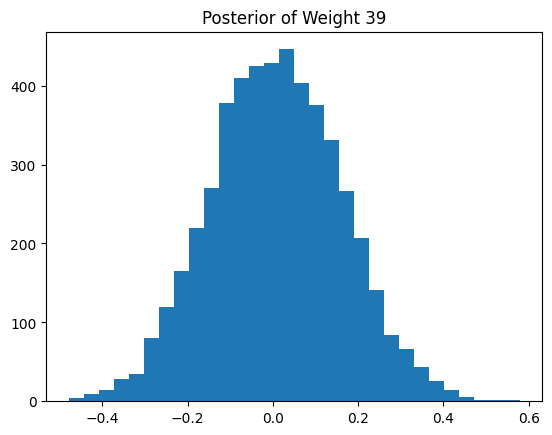

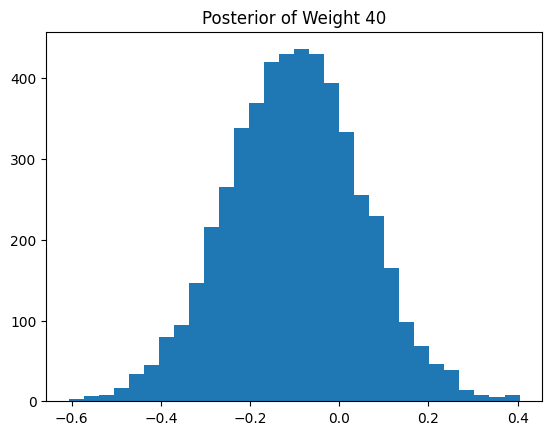

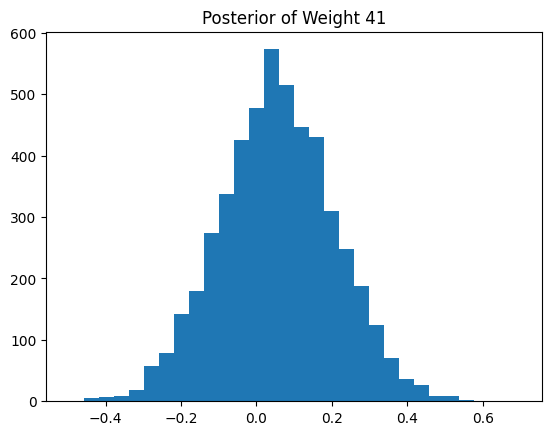

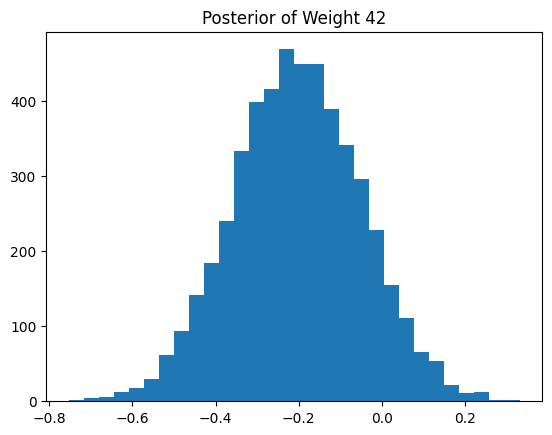

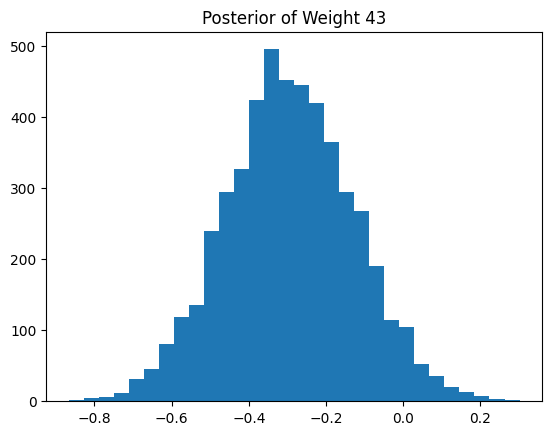

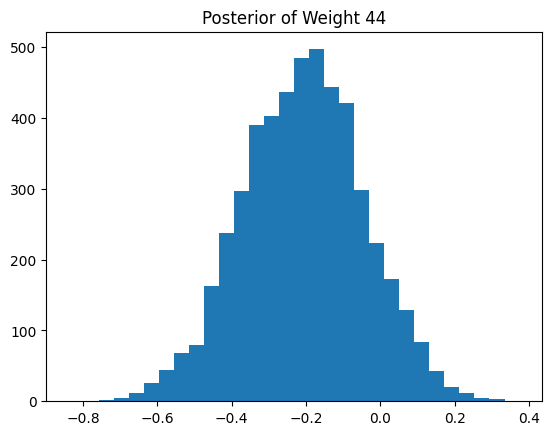

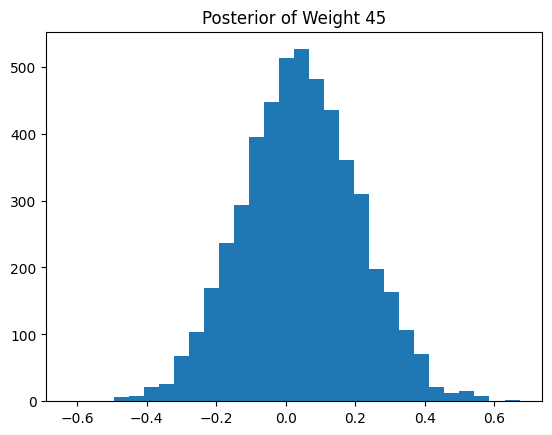

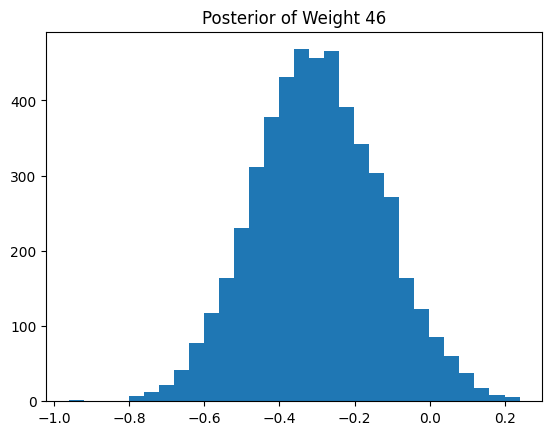

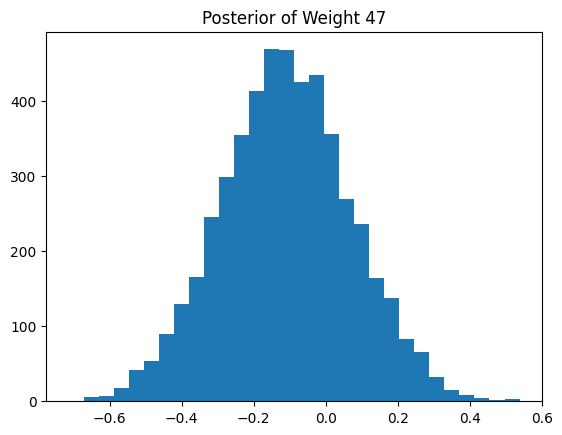

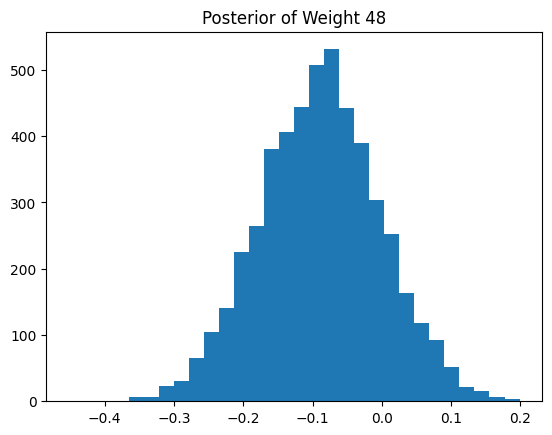

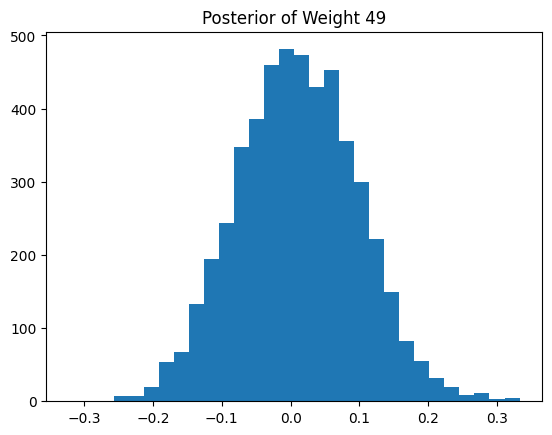

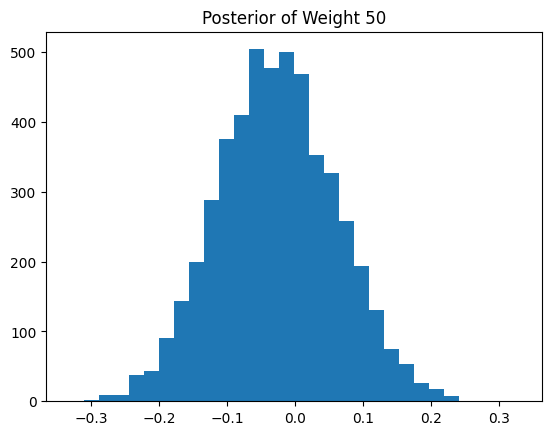

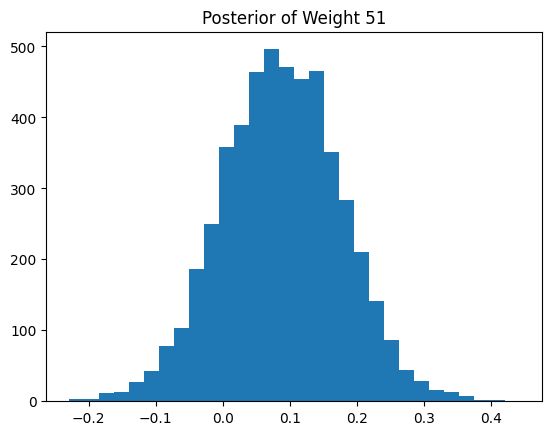

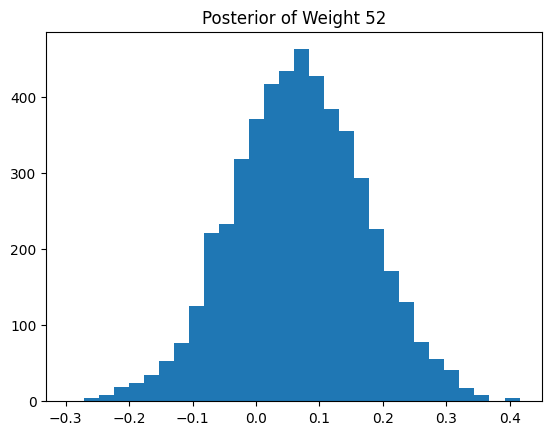

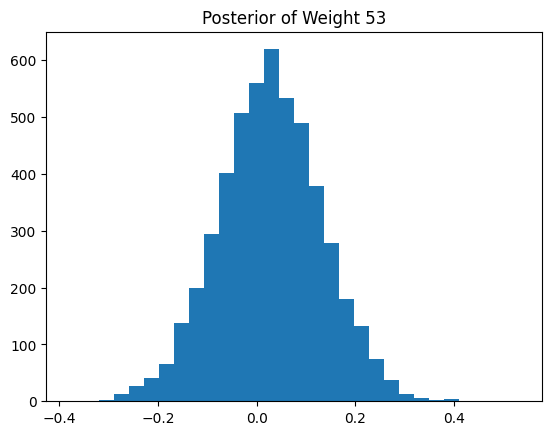

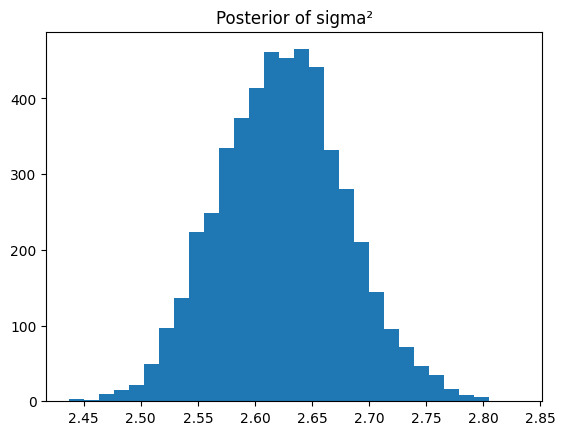

In [61]:
for i in range(p):
  # Visualized posterior of i-th weight
  plt.figure()
  plt.hist(gibbs_samples_w[:, i], bins=30)
  plt.title(f"Posterior of Weight {i}")
  plt.show()

  print() # Separation for format

# Visualized posterior for variance term
plt.figure()
plt.hist(gibbs_samples_sigmay, bins=30)
plt.title("Posterior of sigma²")
plt.show()

### Posterior Predictive Distribution

In [62]:
n_test = X_test.shape[0] # Sample size for test

# Initialize list of posterior predictive samples
posterior_preds = np.zeros((n_test, eta))

# Run the sampler
for i in range(eta):
  mean_preds = X_test @ gibbs_samples_w[i, :].reshape(-1, 1) # Get mean predictions
  noise = norm_rvs_manual(loc=0, scale=np.sqrt(gibbs_samples_sigmay[i]), size=n_test).reshape(-1, 1) # Get the noise
  posterior_preds[:, i] = (mean_preds + noise).flatten() # Add the posterior prediction

# Average posterior predictions over number of observations
posterior_pred_means = posterior_preds.mean(axis=1)

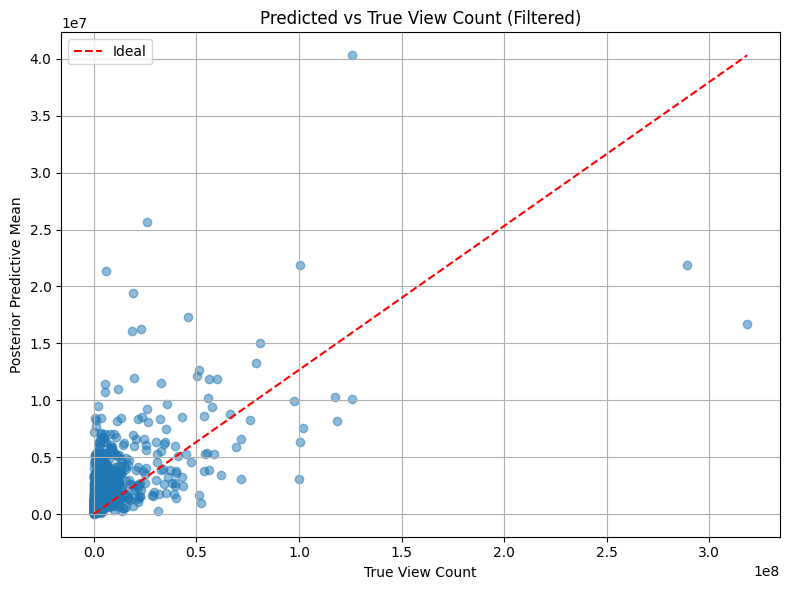

Filtered correlation: 0.5924907770595919


In [69]:
# Exponentiate to compute actual values
y_test_actual = np.expm1(y_test)
preds_actual = np.expm1(posterior_pred_means)

# Remove top 1% of predictions (outliers)
threshold = np.percentile(preds_actual, 99)
mask = preds_actual < threshold

# Use filtered data
filtered_y = y_test_actual[mask]
filtered_preds = preds_actual[mask]

# Plot predictions vs true values for X_test
plt.figure(figsize=(8,6))
plt.scatter(filtered_y, filtered_preds, alpha=0.5)
plt.plot([filtered_y.min(), filtered_y.max()],
         [filtered_preds.min(), filtered_preds.max()], 'r--', label="Ideal")

plt.xlabel("True View Count")
plt.ylabel("Posterior Predictive Mean")
plt.title("Predicted vs True View Count (Filtered)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find correlation of test values to predictions
filtered_corr = np.corrcoef(filtered_y, filtered_preds)[0, 1]
print("Filtered correlation:", filtered_corr)

<ipython-input-64-93c3c91f90f4>:29: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


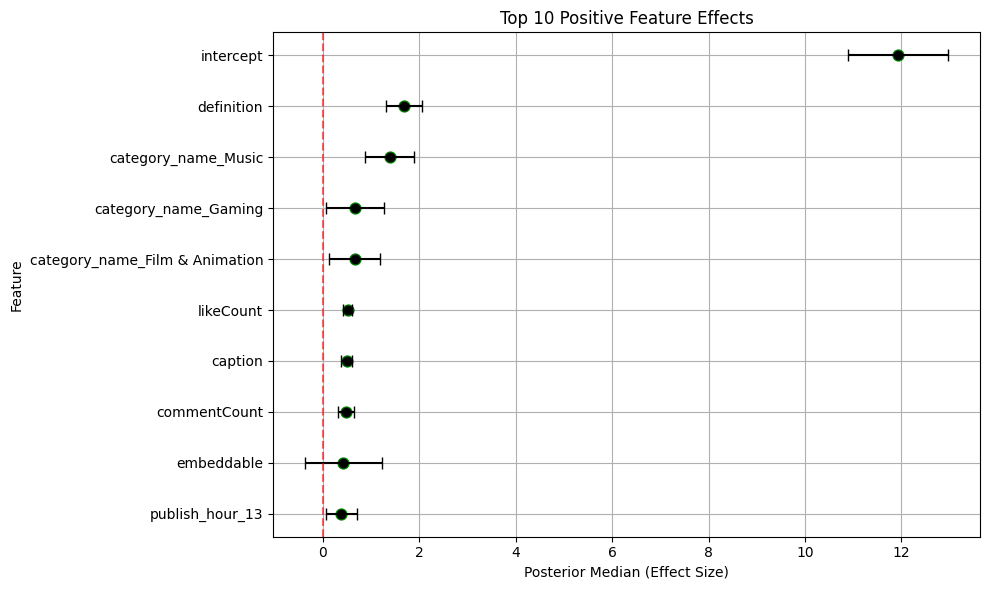

<ipython-input-64-93c3c91f90f4>:29: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


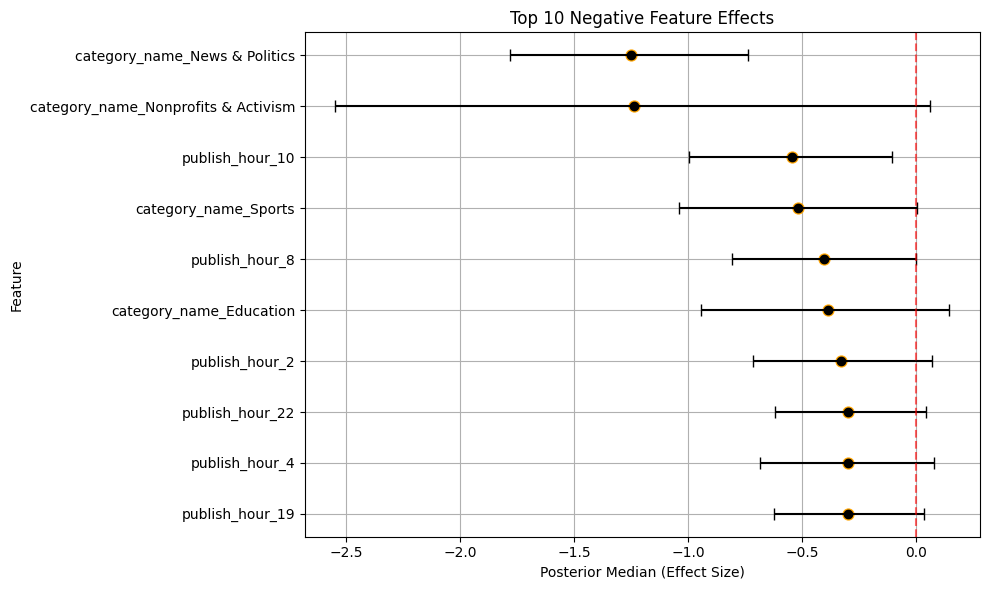

In [64]:
# Find percentiles
summary = np.percentile(gibbs_samples_w, [2.5, 50, 97.5], axis=0)

# Create DataFrame with percentile data
summary_df = pd.DataFrame({
  'feature': feature_names,
  'lower': summary[0],
  'median': summary[1],
  'upper': summary[2]
})

# Separate top 10 positive and top 10 negative based on median
top_positive = summary_df.sort_values(by='median', ascending=False).head(10)
top_negative = summary_df.sort_values(by='median').head(10)

def plot_importance(df, title, color):
  """
  Function to plot the values in the given dataframe

  Args:
    df: Dataframe to plot
    title: Title of the plot
    color: Color of the plot
  """
  # Create figure
  plt.figure(figsize=(10, 6))

  # Plot data with each point being the median
  sns.pointplot(
    data=df,
    y='feature', x='median', join=False,
    color=color, errorbar=None
  )

  # Create whisker plot where error is difference between quartiles
  plt.errorbar(
    x=df['median'],
    y=np.arange(len(df)),
    xerr=[
      df['median'] - df['lower'],
      df['upper'] - df['median']
    ],
    fmt='o', color='black', capsize=4
  )

  # Plot config
  plt.axvline(0, color='red', linestyle='--', alpha=0.6)
  plt.title(title)
  plt.xlabel("Posterior Median (Effect Size)")
  plt.ylabel("Feature")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# Plot top 10 positive and negative features affecting view count
plot_importance(top_positive, "Top 10 Positive Feature Effects", color='green')
plot_importance(top_negative, "Top 10 Negative Feature Effects", color='orange')